## Title:  Predict 90-days mortality for MIMIC-III patients with Septicemia

In [5]:
# Edit all the Mardown cells below with the appropriate information 
# Run all cells, containing your code 
# Save this Jupyter with the outputs of your executed cells
#
# PS: Save again the notebook with this outcome.
# PSPS: Don't forget to include the dataset in your submission

**Team:**
* Satya Prakash Tadisetti
* Shivadath Gannavarapu

**Course:** DAAN 570– Deep Learning (Spring I, 2023)

### Problem Statement
* Septicemia is a life-threatening condition that requires early detection to reduce mortality rates. Traditional statistical models for predicting septicemia have limitations due to its multifactorial nature. The definition of sepsis has evolved over time to facilitate earlier recognition, but the latest version has been criticized for potentially leading to higher mortality rates. In this project, we aim to use the MIMIC-III dataset to build a deep learning model that predicts 90-day mortality for patients with septicemia.
    
    
    
* **Keywords:** Septicemia, early detection, multiple organ failures, mortality rates, traditional statistical models, deep learning models, comprehensive analysis, patient data, multifactorial, challenging task, definition, severity levels, severe sepsis, septic shock, bedside diagnosis, 2016 definition, higher mortality, MIMIC-III dataset, retrospective analysis, Medical Information Mart for Intensive Care, recorded between 2001 and 2012.
	

### Data Collection
* Source(url): https://physionet.org/content/mimiciii/1.4/
* Short Description : The MIMIC-III dataset is a vast and freely available database of electronic health records of patients admitted to Beth Israel Deaconess Medical Center. It contains data on over 40,000 patients admitted between 2001 and 2012, including clinical notes, laboratory test results, medications, and vital signs. The dataset is often used to study sepsis, a potentially life-threatening condition caused by the body's response to infection. By analyzing this data and building predictive models, researchers can identify factors that contribute to mortality in sepsis patients and develop more effective treatment strategies. The MIMIC-III dataset is a valuable resource for researchers and clinicians studying sepsis and other medical conditions.

* Keywords: Septicemia, early detection, multiple organ failures, mortality rates, traditional statistical models, deep learning models, comprehensive analysis, patient data, multifactorial, challenging task, definition, severity levels, severe sepsis, septic shock, bedside diagnosis, 2016 definition, higher mortality, MIMIC-III dataset, retrospective analysis, Medical Information Mart for Intensive Care, recorded between 2001 and 2012.

### Required packages

* Add instructions to install the required packages


In [6]:
# import required libraries
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm


# import tensorflow modules and classes for building the deep learning model
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate

# import evaluation metrics
from sklearn.metrics import confusion_matrix,RocCurveDisplay,ConfusionMatrixDisplay

# import tensorflow-specific libraries
from tensorflow import keras

pd.set_option('display.max_columns',None)


* Load data from local file into pandas dataframes*

In [7]:
# patient information such as gender, date of birth, and date of death
patients = pd.read_csv('PATIENTS.csv')

# admission information such as admission and discharge dates, and admission type
admissions = pd.read_csv('ADMISSIONS.csv') 

# laboratory measurements for each patient
labevents = pd.read_csv('LABEVENTS.csv') 

# ICU stay information such as admission and discharge dates, and length of stay
icustays = pd.read_csv('ICUSTAYS.csv') 

# diagnoses codes for each patient admission
diagnoses = pd.read_csv('DIAGNOSES_ICD.csv') 

# information about each lab test, including the test name and normal ranges
d_labitems = pd.read_csv('D_LABITEMS.csv') 

In [8]:
#List of ICD-9 codes associated with sepsis
sepsis_icd9 = ['31','202','223','380','382','383','388','389','545','3810','3811','3812','3819','3841','3842','3843','3844','3849','65930','65931','65933','67020','67022','67024','77181','78552','99591','99592']

### The code below analyzes the DIAGNOSES dataset from MIMIC-III

In [9]:
#Display the shape and first 5 rows of the dataset
print(f"Shape of the diagnoses dataset is :{diagnoses.shape}")
diagnoses.head(5)

Shape of the diagnoses dataset is :(651047, 5)


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [10]:
#Drop the ROW_ID and SEQ_NUM columns from the dataset
diagnoses.drop(['ROW_ID','SEQ_NUM'],axis=1,inplace=True)

#Display information about the dataset
diagnoses.info()

#Filter the dataset to only include ICD9 codes related to sepsis
diagnoses = diagnoses[diagnoses['ICD9_CODE'].isin(sepsis_icd9)]

#Display the new shape and first 5 rows of the filtered dataset
print(f"Shape of the diagnoses dataset is :{diagnoses.shape}")
diagnoses.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   SUBJECT_ID  651047 non-null  int64 
 1   HADM_ID     651047 non-null  int64 
 2   ICD9_CODE   651000 non-null  object
dtypes: int64(2), object(1)
memory usage: 14.9+ MB
Shape of the diagnoses dataset is :(7995, 3)


,SUBJECT_ID,HADM_ID,ICD9_CODE
87,117,164853,99592
144,124,138376,99592
276,64,172056,99591
450,85,112077,99591
497,92,142807,77181


### The code below analyzes the PATIENTS dataset from MIMIC-III

In [11]:
#Display the shape and first 5 rows of the dataset
print(f"Shape of the patients dataset is :{patients.shape}")
patients.head(5)

Shape of the patients dataset is :(46520, 8)


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [12]:
#Print information about the dataset
patients.info()

#Drop unnecessary columns from the dataset
patients.drop(['ROW_ID','DOD','DOD_HOSP','DOD_SSN','EXPIRE_FLAG'],axis=1,inplace=True)

#Display the new shape and first 5 rows of the dataset
print("Shape of the patients data is : ",patients.shape)
patients.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       46520 non-null  int64 
 1   SUBJECT_ID   46520 non-null  int64 
 2   GENDER       46520 non-null  object
 3   DOB          46520 non-null  object
 4   DOD          15759 non-null  object
 5   DOD_HOSP     9974 non-null   object
 6   DOD_SSN      13378 non-null  object
 7   EXPIRE_FLAG  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB
Shape of the patients data is :  (46520, 3)


,SUBJECT_ID,GENDER,DOB
0,249,F,2075-03-13 00:00:00
1,250,F,2164-12-27 00:00:00
2,251,M,2090-03-15 00:00:00
3,252,M,2078-03-06 00:00:00
4,253,F,2089-11-26 00:00:00


###  Merge the diagnoses and patients dataframes based on the SUBJECT_ID 

In [13]:
patietns_diagnoses = pd.merge(diagnoses,patients,how='inner',on=['SUBJECT_ID'])

### The code below analyzes the ADMISSIONS dataset from MIMIC-III

In [14]:
# Print information about the admissions dataset
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                58976 non-null  int64 
 1   SUBJECT_ID            58976 non-null  int64 
 2   HADM_ID               58976 non-null  int64 
 3   ADMITTIME             58976 non-null  object
 4   DISCHTIME             58976 non-null  object
 5   DEATHTIME             5854 non-null   object
 6   ADMISSION_TYPE        58976 non-null  object
 7   ADMISSION_LOCATION    58976 non-null  object
 8   DISCHARGE_LOCATION    58976 non-null  object
 9   INSURANCE             58976 non-null  object
 10  LANGUAGE              33644 non-null  object
 11  RELIGION              58518 non-null  object
 12  MARITAL_STATUS        48848 non-null  object
 13  ETHNICITY             58976 non-null  object
 14  EDREGTIME             30877 non-null  object
 15  EDOUTTIME             30877 non-null

In [15]:
# Define a list of columns to drop from the admissions dataset
cols = ['ROW_ID','DISCHTIME','EDREGTIME','EDOUTTIME','ADMISSION_LOCATION','INSURANCE','DISCHARGE_LOCATION','LANGUAGE','RELIGION','MARITAL_STATUS','ETHNICITY','HOSPITAL_EXPIRE_FLAG','HAS_CHARTEVENTS_DATA']

# Drop the specified columns from the admissions dataset
admissions.drop(cols,axis=1,inplace=True)

# Print the shape of the resulting admissions dataset and the first 5 rows
print("Shape of the admissions data is : ",admissions.shape)
admissions.head(5)

Shape of the admissions data is :  (58976, 6)


,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,DIAGNOSIS
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,BENZODIAZEPINE OVERDOSE
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,BRAIN MASS
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,INTERIOR MYOCARDIAL INFARCTION
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,ACUTE CORONARY SYNDROME


### Merge the admissions and patients_diagnoses datasets

In [16]:
#pat_diag_Adm will contain only the rows that have matching SUBJECT_ID and HADM_ID values in both admissions and diagnoses datasets.
#The 'inner' merge is used here so that only matching rows are retained, with other rows being dropped.
pat_diag_ad = pd.merge(admissions,patietns_diagnoses,how='inner',on=['SUBJECT_ID','HADM_ID'])

In [17]:
# Display the shape and first 5 rows of the merged dataset
print(f"Shape of the merged dataset is :{pat_diag_ad .shape}")
pat_diag_ad .head(5)

Shape of the merged dataset is :(7995, 9)


,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,DIAGNOSIS,ICD9_CODE,GENDER,DOB
0,38,185910,2166-08-10 00:28:00,NaN,EMERGENCY,ACUTE MYOCARDIAL INFARCTION-SEPSIS,99592,M,2090-08-31 00:00:00
1,357,145674,2198-08-02 04:49:00,NaN,EMERGENCY,SEIZURE,99592,M,2135-03-22 00:00:00
2,357,145674,2198-08-02 04:49:00,NaN,EMERGENCY,SEIZURE,78552,M,2135-03-22 00:00:00
3,357,122609,2198-11-01 22:36:00,NaN,EMERGENCY,SEPSIS,99592,M,2135-03-22 00:00:00
4,366,134462,2164-11-18 20:27:00,NaN,EMERGENCY,SEPSIS,99591,M,2112-05-22 00:00:00


In [18]:
# Convert columns to datetime format
pat_diag_ad['DOB'] = pd.to_datetime(pat_diag_ad['DOB'])
pat_diag_ad['ADMITTIME'] = pd.to_datetime(pat_diag_ad['ADMITTIME'])
pat_diag_ad['DEATHTIME'] = pd.to_datetime(pat_diag_ad['DEATHTIME'])

### DOB

* DOB is the date of birth of the given patient. Patients who are older than 89 years old at any time in the database have had their date of birth shifted to obscure their age and comply with HIPAA. The shift process was as follows: the patient’s age at their first admission was determined. The date of birth was then set to exactly 300 years before their first admission.

* Reference: https://mimic.mit.edu/docs/iii/tables/patients/#dob*

In [19]:
# Define a function to calculate the age of the patient
def patient_age(df):
    
    #Convert date of birth to datetime object
    dob = pd.to_datetime(df['DOB']).to_pydatetime()
    
    ## Convert admission time to datetime object
    admittime = pd.to_datetime(df['ADMITTIME']).to_pydatetime()
    
    # Calculate age by subtracting date of birth from admission time and dividing by 365
    age = (admittime - dob).days // 365
    
    # If age is greater than or equal to 300, set it to 90 + the difference between 300 and the calculated age
    if age >= 300:
        return 90 + abs(300-age)
    else:
        # Otherwise, return the calculated age
        return age

# Apply the patient_age function to each row in the PDA dataframe to create a new column called AGE
pat_diag_ad['AGE'] = pat_diag_ad.apply(lambda x: patient_age(x), axis=1)

In [20]:
def period(row, period):
    """
    A function that takes a row and a time period as inputs, and returns whether the patient has died 
    within the given time period after admission.
    
    Parameters:
    row (pandas.Series): a row of the merged dataset
    period (pandas.Timedelta): a time period in pandas.Timedelta format
    
    Returns:
    int: 1 if patient died within the time period after admission, 0 otherwise
    """
    if pd.isna(row['DEATHTIME']):
        return 0
    
    elif row['DEATHTIME'] - row['ADMITTIME'] > period:
        return 0
    
    else:
        return 1
    
# Add a new column 'DEATH_WITHIN_90_DAYS' to the merged dataset indicating whether the patient 
# died within 90 days after admission
pat_diag_ad['DEATH_WITHIN_90_DAYS'] = pat_diag_ad.apply (lambda row: period (row, pd.Timedelta('90 days')),axis=1)

# Add a new column 'DEATH_WITHIN_60_DAYS' to the merged dataset indicating whether the patient 
# died within 60 days after admission
pat_diag_ad['DEATH_WITHIN_60_DAYS'] = pat_diag_ad.apply (lambda row: period (row, pd.Timedelta('60 days')),axis=1)

# Add a new column 'DEATH_WITHIN_30_DAYS' to the merged dataset indicating whether the patient 
# died within 30 days after admission
pat_diag_ad['DEATH_WITHIN_30_DAYS'] = pat_diag_ad.apply (lambda row: period (row, pd.Timedelta('30 days')),axis=1)


### The code below analyzes the LABEVENTS dataset from MIMIC-III

In [21]:
#Display the shape and first 5 rows of the dataset
print(f"Shape of the Labevents dataset is :{labevents.shape}")
labevents.head(5)

Shape of the Labevents dataset is :(27854055, 9)


,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal


In [22]:
#Drop unnecessary columns from the dataset
labevents.drop(['CHARTTIME','VALUE','ROW_ID'],axis=1,inplace=True)

### Merge labevents dataset with pat_diag_ad dataset based on subject ID and hospital admission ID

In [23]:
pat_diag_ad_le = pd.merge(labevents,pat_diag_ad,how='inner',on=['SUBJECT_ID','HADM_ID'])

In [24]:
#Display shape and first 5 rows of the merged dataset
print(f"Shape of the merged dataset is :{pat_diag_ad_le.shape}")
pat_diag_ad_le.head(5)

Shape of the merged dataset is :(6256333, 17)


,SUBJECT_ID,HADM_ID,ITEMID,VALUENUM,VALUEUOM,FLAG,ADMITTIME,DEATHTIME,ADMISSION_TYPE,DIAGNOSIS,ICD9_CODE,GENDER,DOB,AGE,DEATH_WITHIN_90_DAYS,DEATH_WITHIN_60_DAYS,DEATH_WITHIN_30_DAYS
0,21,111970.0,51279,2.81,m/uL,abnormal,2135-01-30 20:50:00,2135-02-08 02:08:00,EMERGENCY,SEPSIS,78552,M,2047-04-04,87,1,1,1
1,21,111970.0,51279,2.81,m/uL,abnormal,2135-01-30 20:50:00,2135-02-08 02:08:00,EMERGENCY,SEPSIS,99592,M,2047-04-04,87,1,1,1
2,21,111970.0,51301,26.80,K/uL,abnormal,2135-01-30 20:50:00,2135-02-08 02:08:00,EMERGENCY,SEPSIS,78552,M,2047-04-04,87,1,1,1
3,21,111970.0,51301,26.80,K/uL,abnormal,2135-01-30 20:50:00,2135-02-08 02:08:00,EMERGENCY,SEPSIS,99592,M,2047-04-04,87,1,1,1
4,21,111970.0,50800,NaN,NaN,NaN,2135-01-30 20:50:00,2135-02-08 02:08:00,EMERGENCY,SEPSIS,78552,M,2047-04-04,87,1,1,1


### The code below analyzes the PATIENTS dataset from MIMIC-III

In [25]:
#Display shape and first 5 rows of the dataset
print(f"Shape of the ICUSTAYS dataset is :{icustays.shape}")
icustays.head(5)

Shape of the ICUSTAYS dataset is :(61532, 12)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [26]:
# Drop the specified columns from the admissions dataset
icustays.drop(['ROW_ID','ICUSTAY_ID','DBSOURCE','INTIME','FIRST_WARDID','LAST_WARDID','OUTTIME'],axis=1,inplace=True)

#Display shape and first 5 rows of the dataset
print(f"Shape of the ICUSTAYS dataset is :{icustays.shape}")
icustays.head(5)

Shape of the ICUSTAYS dataset is :(61532, 5)


,SUBJECT_ID,HADM_ID,FIRST_CAREUNIT,LAST_CAREUNIT,LOS
0,268,110404,MICU,MICU,3.2490
1,269,106296,MICU,MICU,3.2788
2,270,188028,CCU,CCU,2.8939
3,271,173727,MICU,SICU,2.0600
4,272,164716,CCU,CCU,1.6202


### Merge Icustays dataset with pat_diag_ad_le dataset based on subject ID and hospital admission ID

In [27]:
pat_diag_ad_le_icust = pd.merge(icustays,pat_diag_ad_le,how='inner',on=['SUBJECT_ID','HADM_ID'])

### The code below analyzes the D_labevents dataset from MIMIC-III

In [28]:
#Display shape and first 5 rows of the dataset
print(f"Shape of the D_labitems dataset is :{d_labitems.shape}")
d_labitems.head(5)

Shape of the D_labitems dataset is :(753, 6)


,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
0,546,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,26447-3
1,547,51347,Eosinophils,Cerebrospinal Fluid (CSF),Hematology,26451-5
2,548,51348,"Hematocrit, CSF",Cerebrospinal Fluid (CSF),Hematology,30398-2
3,549,51349,Hypersegmented Neutrophils,Cerebrospinal Fluid (CSF),Hematology,26506-6
4,550,51350,Immunophenotyping,Cerebrospinal Fluid (CSF),Hematology,NaN


In [29]:
# Drop the specified columns from the admissions dataset
d_labitems.drop(['ROW_ID','LOINC_CODE'],axis=1,inplace=True)

In [30]:
#Display shape and first 5 rows of the dataset
print(f"Shape of the D-Labitems dataset is :{d_labitems.shape}")
d_labitems.head(5)

Shape of the D-Labitems dataset is :(753, 4)


,ITEMID,LABEL,FLUID,CATEGORY
0,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology
1,51347,Eosinophils,Cerebrospinal Fluid (CSF),Hematology
2,51348,"Hematocrit, CSF",Cerebrospinal Fluid (CSF),Hematology
3,51349,Hypersegmented Neutrophils,Cerebrospinal Fluid (CSF),Hematology
4,51350,Immunophenotyping,Cerebrospinal Fluid (CSF),Hematology


### Merge Icustays dataset with pat_diag_ad_le_icust dataset based on subject ID and hospital admission ID

In [31]:
final = pd.merge(d_labitems,pat_diag_ad_le_icust, how='inner',on=['ITEMID']) 

* The below dataset is the final dataset after merging the the required tables

In [32]:
#Display shape and first 5 rows of the dataset
print(f"Shape of the merged dataset is :{final.shape}")
final.head(5)

Shape of the merged dataset is :(8310319, 23)


,ITEMID,LABEL,FLUID,CATEGORY,SUBJECT_ID,HADM_ID,FIRST_CAREUNIT,LAST_CAREUNIT,LOS,VALUENUM,VALUEUOM,FLAG,ADMITTIME,DEATHTIME,ADMISSION_TYPE,DIAGNOSIS,ICD9_CODE,GENDER,DOB,AGE,DEATH_WITHIN_90_DAYS,DEATH_WITHIN_60_DAYS,DEATH_WITHIN_30_DAYS
0,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,24915,194424,MICU,MICU,64.9855,67.0,%,NaN,2182-11-11 20:01:00,2183-01-15 15:00:00,EMERGENCY,SEPSIS,99592,F,2129-04-20,53,1,0,0
1,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,91333,112508,MICU,MICU,8.4912,59.0,%,NaN,2176-02-27 17:39:00,2176-05-15 18:45:00,EMERGENCY,RECURRENT LEUKEMIA,99592,F,2115-11-10,60,1,0,0
2,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,91333,112508,MICU,MICU,8.4912,59.0,%,NaN,2176-02-27 17:39:00,2176-05-15 18:45:00,EMERGENCY,RECURRENT LEUKEMIA,78552,F,2115-11-10,60,1,0,0
3,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,91333,112508,MICU,MICU,8.4912,80.0,%,NaN,2176-02-27 17:39:00,2176-05-15 18:45:00,EMERGENCY,RECURRENT LEUKEMIA,99592,F,2115-11-10,60,1,0,0
4,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,91333,112508,MICU,MICU,8.4912,80.0,%,NaN,2176-02-27 17:39:00,2176-05-15 18:45:00,EMERGENCY,RECURRENT LEUKEMIA,78552,F,2115-11-10,60,1,0,0


In [33]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8310319 entries, 0 to 8310318
Data columns (total 23 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ITEMID                int64         
 1   LABEL                 object        
 2   FLUID                 object        
 3   CATEGORY              object        
 4   SUBJECT_ID            int64         
 5   HADM_ID               int64         
 6   FIRST_CAREUNIT        object        
 7   LAST_CAREUNIT         object        
 8   LOS                   float64       
 9   VALUENUM              float64       
 10  VALUEUOM              object        
 11  FLAG                  object        
 12  ADMITTIME             datetime64[ns]
 13  DEATHTIME             datetime64[ns]
 14  ADMISSION_TYPE        object        
 15  DIAGNOSIS             object        
 16  ICD9_CODE             object        
 17  GENDER                object        
 18  DOB                   datetime64[ns]
 19  

In [34]:
final.isna().sum()

ITEMID                        0
LABEL                         0
FLUID                         0
CATEGORY                      0
SUBJECT_ID                    0
HADM_ID                       0
FIRST_CAREUNIT                0
LAST_CAREUNIT                 0
LOS                           0
VALUENUM                 713779
VALUEUOM                 889791
FLAG                    4762261
ADMITTIME                     0
DEATHTIME               4983122
ADMISSION_TYPE                0
DIAGNOSIS                     0
ICD9_CODE                     0
GENDER                        0
DOB                           0
AGE                           0
DEATH_WITHIN_90_DAYS          0
DEATH_WITHIN_60_DAYS          0
DEATH_WITHIN_30_DAYS          0
dtype: int64

### Data Preprocessing

* Enumerate and present the main steps you preformed in the data preprocessing
* Add your code and interpret the outcome of main steps/functions


In [35]:
## Your code begins here

In [36]:
#Display the shape and first 5 rows of the final dataset
print("Shape of the dataset is : ",final.shape)
final.head(5)

Shape of the dataset is :  (8310319, 23)


,ITEMID,LABEL,FLUID,CATEGORY,SUBJECT_ID,HADM_ID,FIRST_CAREUNIT,LAST_CAREUNIT,LOS,VALUENUM,VALUEUOM,FLAG,ADMITTIME,DEATHTIME,ADMISSION_TYPE,DIAGNOSIS,ICD9_CODE,GENDER,DOB,AGE,DEATH_WITHIN_90_DAYS,DEATH_WITHIN_60_DAYS,DEATH_WITHIN_30_DAYS
0,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,24915,194424,MICU,MICU,64.9855,67.0,%,NaN,2182-11-11 20:01:00,2183-01-15 15:00:00,EMERGENCY,SEPSIS,99592,F,2129-04-20,53,1,0,0
1,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,91333,112508,MICU,MICU,8.4912,59.0,%,NaN,2176-02-27 17:39:00,2176-05-15 18:45:00,EMERGENCY,RECURRENT LEUKEMIA,99592,F,2115-11-10,60,1,0,0
2,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,91333,112508,MICU,MICU,8.4912,59.0,%,NaN,2176-02-27 17:39:00,2176-05-15 18:45:00,EMERGENCY,RECURRENT LEUKEMIA,78552,F,2115-11-10,60,1,0,0
3,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,91333,112508,MICU,MICU,8.4912,80.0,%,NaN,2176-02-27 17:39:00,2176-05-15 18:45:00,EMERGENCY,RECURRENT LEUKEMIA,99592,F,2115-11-10,60,1,0,0
4,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,91333,112508,MICU,MICU,8.4912,80.0,%,NaN,2176-02-27 17:39:00,2176-05-15 18:45:00,EMERGENCY,RECURRENT LEUKEMIA,78552,F,2115-11-10,60,1,0,0


In [37]:
#Removing the subject's which are having age less than to 18
final = final[final.AGE>18]

#Drop the columns which are no longer needed for analysis
final.drop(['DOB','DEATHTIME','ADMITTIME'],axis=1,inplace=True)

#Display the shape of the final dataset
final.shape

(8182130, 20)

In [38]:
'''Count the number of patients who died within 90 days of admission

Here, final is the merged dataset of all relevant datasets

DEATH_WITHIN_30_DAYS,DEATH_WITHIN_60_DAYS and DEATH_WITHIN_90_DAYS is a newly created column with boolean values indicating whether the patient died within 30,60,90 days of admission or not

value_counts() method counts the number of unique values in the specified column'''
print("Death within 30 days : ",final.DEATH_WITHIN_30_DAYS.value_counts())
print("Death within 60 days : ",final.DEATH_WITHIN_60_DAYS.value_counts())
print("Death within 90 days : ",final.DEATH_WITHIN_90_DAYS.value_counts())

Death within 30 days :  0    6348289
1    1833841
Name: DEATH_WITHIN_30_DAYS, dtype: int64
Death within 60 days :  0    5601999
1    2580131
Name: DEATH_WITHIN_60_DAYS, dtype: int64
Death within 90 days :  0    5302292
1    2879838
Name: DEATH_WITHIN_90_DAYS, dtype: int64


In [39]:
# group the DataFrame by SUBJECT_ID and get the maximum value of DEATH_WITHIN_30_DAYS for each group
death_within_30_days = final.groupby('SUBJECT_ID')['DEATH_WITHIN_30_DAYS'].max()

# group the DataFrame by SUBJECT_ID and get the maximum value of DEATH_WITHIN_60_DAYS for each group
death_within_60_days = final.groupby('SUBJECT_ID')['DEATH_WITHIN_60_DAYS'].max()

# group the DataFrame by SUBJECT_ID and get the maximum value of DEATH_WITHIN_90_DAYS for each group
death_within_90_days = final.groupby('SUBJECT_ID')['DEATH_WITHIN_90_DAYS'].max()

# the result is a pandas Series object with SUBJECT_ID as the index and the maximum value of DEATH_WITHIN_90_DAYS for each group
print("Death within 30 days : ",death_within_30_days)
print('--'*20)
print("Death within 60 days : ",death_within_60_days)
print('--'*20)
print("Death within 90 days : ",death_within_90_days)

Death within 30 days :  SUBJECT_ID
21       1
38       0
61       1
62       0
64       0
        ..
99836    0
99865    1
99912    0
99985    0
99991    0
Name: DEATH_WITHIN_30_DAYS, Length: 4670, dtype: int64
----------------------------------------
Death within 60 days :  SUBJECT_ID
21       1
38       0
61       1
62       0
64       0
        ..
99836    0
99865    1
99912    0
99985    0
99991    0
Name: DEATH_WITHIN_60_DAYS, Length: 4670, dtype: int64
----------------------------------------
Death within 90 days :  SUBJECT_ID
21       1
38       0
61       1
62       0
64       0
        ..
99836    0
99865    1
99912    0
99985    0
99991    0
Name: DEATH_WITHIN_90_DAYS, Length: 4670, dtype: int64


In [40]:
#Grouping the final dataset by 'HADM_ID', 'FLUID', and 'ITEMID' to count the number of times an item was measured during an admission
req_data = pd.DataFrame(final.groupby(['HADM_ID','FLUID','ITEMID'])['ITEMID'].count())

#Renaming the count column to 'item_count'
req_data.rename(columns={'ITEMID': 'item_count'}, inplace=True)

#Reseting the index to convert 'HADM_ID', 'FLUID', and 'ITEMID' columns from the grouped data to separate columns
req_data.reset_index(drop=False, inplace=True)

In [41]:
req_data.sort_values(by='item_count', ascending=False, inplace=True)
print(req_data.shape)
req_data.head(5)

(476067, 4)


,HADM_ID,FLUID,ITEMID,item_count
74887,115396,Blood,51265,2728
152592,131118,Blood,51221,2260
152554,131118,Blood,50971,2210
152559,131118,Blood,50983,2140
152528,131118,Blood,50902,2140


In [42]:
len(req_data[req_data.item_count>700])

315

In [43]:
gd = req_data[req_data.item_count>700]
#Creating a list of item ids

#req_data: a pandas DataFrame containing the required data

#item_ids_list: a list containing all the item ids from the given DataFrame

item_ids_list = list(gd.ITEMID)

In [44]:
#Create a copy of final dataframe
final_1 = final.copy()

#Create another copy of final dataframe
final_cp = final.copy()

In [45]:
#Filter the final_1 dataframe to keep only the rows with ITEMIDs that are in the item_ids_list
final_1 = final_1[final_1.ITEMID.isin(item_ids_list)]

In [46]:
#The code displays the first 5 rows of the final preprocessed dataset after merging and processing the required datasets to be used for the prediction model
print(final_1.shape)
final_1.head(5)

(6910507, 20)


,ITEMID,LABEL,FLUID,CATEGORY,SUBJECT_ID,HADM_ID,FIRST_CAREUNIT,LAST_CAREUNIT,LOS,VALUENUM,VALUEUOM,FLAG,ADMISSION_TYPE,DIAGNOSIS,ICD9_CODE,GENDER,AGE,DEATH_WITHIN_90_DAYS,DEATH_WITHIN_60_DAYS,DEATH_WITHIN_30_DAYS
82834,50800,SPECIMEN TYPE,BLOOD,BLOOD GAS,269,106296,MICU,MICU,3.2788,NaN,NaN,NaN,EMERGENCY,SEPSIS;PILONIDAL ABSCESS,78552,M,40,0,0,0
82835,50800,SPECIMEN TYPE,BLOOD,BLOOD GAS,269,106296,MICU,MICU,3.2788,NaN,NaN,NaN,EMERGENCY,SEPSIS;PILONIDAL ABSCESS,99592,M,40,0,0,0
82836,50800,SPECIMEN TYPE,BLOOD,BLOOD GAS,269,106296,MICU,MICU,3.2788,NaN,NaN,NaN,EMERGENCY,SEPSIS;PILONIDAL ABSCESS,78552,M,40,0,0,0
82837,50800,SPECIMEN TYPE,BLOOD,BLOOD GAS,269,106296,MICU,MICU,3.2788,NaN,NaN,NaN,EMERGENCY,SEPSIS;PILONIDAL ABSCESS,99592,M,40,0,0,0
82838,50800,SPECIMEN TYPE,BLOOD,BLOOD GAS,269,106296,MICU,MICU,3.2788,NaN,NaN,NaN,EMERGENCY,SEPSIS;PILONIDAL ABSCESS,78552,M,40,0,0,0


In [47]:
#Creating a pivot table 'final_2' from 'final_1' dataset, to transform the 'LABEL' column into columns and 'VALUENUM' column into values

#'SUBJECT_ID' column is set as the index column

final_2 = final_1.pivot_table(columns='LABEL',values='VALUENUM',index=['SUBJECT_ID']).reset_index()

In [48]:
#This line of code sets the name of the columns' index to None. In pandas, data frames have two indexes - row index and column index. Column index can have a name or can be nameless. 
#If a column index has a name, it will be displayed when you print the data frame, otherwise, it will be displayed as None. 
#Setting the column index name to None removes the column index name from the data frame
final_2.columns.name=None

In [49]:
#This code is checking for missing values in the "final_2" dataset using the "isna()" function and then calculating the sum of all missing values for each column using the "sum()" function.
final_2.isna().sum()

SUBJECT_ID                            0
Alanine Aminotransferase (ALT)      300
Alkaline Phosphatase                324
Anion Gap                             2
Asparate Aminotransferase (AST)     298
Atypical Lymphocytes               1446
Bands                              1052
Base Excess                         746
Basophils                           129
Bicarbonate                           1
Bilirubin, Total                    295
Calcium, Total                       23
Calculated Total CO2                746
Chloride                              1
Creatinine                            0
Eosinophils                         129
Fibrinogen, Functional             2383
Free Calcium                       1505
Glucose                               2
Hematocrit                            0
Hemoglobin                            2
INR(PT)                              54
Lactate                             132
Lactate Dehydrogenase (LD)          896
Lymphocytes                         129


In [50]:
# Create a DataFrame from the output of final_2.isna().sum()
df_missing = pd.DataFrame(final_2.isna().sum(), columns=['missing_values']).reset_index()
df_missing = df_missing.drop(index=0).reset_index(drop=True)

# Select columns with more than 100 missing values
labels_list = list(df_missing.loc[df_missing['missing_values'] > 100, 'index'])

# Impute missing values with mean imputation
imputer = SimpleImputer(strategy='mean')
imputer.fit(final_2.loc[:, labels_list])
final_2.loc[:, labels_list] = imputer.transform(final_2.loc[:, labels_list])

In [51]:
#Drop rows with missing values
final_2.dropna(inplace=True)

In [52]:
#Display the first 5 rows of the final_2 dataset
print(final_2.shape)
final_2.head(5)

(4594, 49)


,SUBJECT_ID,Alanine Aminotransferase (ALT),Alkaline Phosphatase,Anion Gap,Asparate Aminotransferase (AST),Atypical Lymphocytes,Bands,Base Excess,Basophils,Bicarbonate,"Bilirubin, Total","Calcium, Total",Calculated Total CO2,Chloride,Creatinine,Eosinophils,"Fibrinogen, Functional",Free Calcium,Glucose,Hematocrit,Hemoglobin,INR(PT),Lactate,Lactate Dehydrogenase (LD),Lymphocytes,MCH,MCHC,MCV,Magnesium,Metamyelocytes,Monocytes,Myelocytes,Neutrophils,Oxygen,PEEP,PT,PTT,Phosphate,Platelet Count,Potassium,RDW,Red Blood Cells,Sodium,Temperature,Urea Nitrogen,White Blood Cells,pCO2,pH,pO2
0,21,38.500000,151.166667,13.666667,63.333333,0.000000,0.333333,-0.750000,0.025000,23.777778,0.250000,7.562500,25.750000,106.000000,3.090000,0.225,344.000000,1.108592,170.444444,27.292857,8.430000,1.514286,1.985714,257.666667,4.05,30.060000,30.680000,98.100000,1.822222,1.0,2.80,1.0,91.675,28.000000,7.413939,16.428571,33.357143,3.637500,321.900000,3.880000,17.850000,2.804000,139.444444,37.260000,37.800000,29.080000,40.750000,7.392500,56.750000
1,38,205.000000,111.250000,9.657143,195.400000,0.000000,0.500000,1.547170,0.050000,25.285714,1.075000,7.859375,26.905660,107.828571,1.108571,1.000,437.917552,1.155000,115.416667,29.436842,9.977419,1.425000,2.012500,319.666667,24.20,31.419355,33.600000,93.548387,1.845946,0.0,8.40,0.0,65.850,45.142857,5.187500,14.462500,38.733333,2.877419,117.906250,4.085366,14.896774,3.172903,138.675676,37.457143,24.771429,7.583871,40.377358,7.417593,139.924528
2,61,81.571429,252.190476,10.794118,111.000000,0.000000,15.000000,-5.000000,0.000000,24.147059,0.835000,7.800000,16.500000,106.264706,0.385294,0.000,139.400000,1.108592,132.382353,25.071429,8.855000,0.866667,2.900000,1173.041667,6.00,29.902500,34.917500,85.775000,1.870000,0.5,2.00,1.5,75.000,58.158110,7.413939,11.794118,29.022222,2.545000,23.888889,3.574419,17.275000,2.959000,137.588235,37.065840,21.411765,0.681081,22.000000,7.475000,68.500000
3,62,15.000000,42.000000,10.181818,18.000000,0.333333,4.666667,0.000000,0.033333,23.272727,0.300000,7.800000,24.000000,109.363636,0.690909,0.250,437.917552,1.145000,134.090909,33.590000,11.530000,1.150000,2.381818,189.000000,10.55,32.120000,34.340000,93.600000,1.890000,0.0,3.35,0.0,81.000,58.158110,7.413939,13.400000,30.400000,2.650000,146.600000,3.945455,13.700000,3.590000,138.909091,36.400000,22.454545,9.170000,37.000000,7.376667,35.000000
4,64,187.285714,146.666667,14.300000,44.000000,0.000000,19.000000,-2.273887,0.000000,21.900000,1.328571,6.550000,23.731432,103.800000,0.954545,0.000,477.000000,1.108592,111.900000,24.930769,8.372727,1.150000,2.672018,461.000000,9.00,26.481818,33.018182,80.363636,1.611111,0.0,4.00,0.0,68.000,58.158110,7.413939,13.150000,30.450000,2.680000,209.909091,3.483333,14.545455,3.158182,136.500000,37.065840,12.727273,13.481818,40.620176,7.356356,111.553780


In [53]:
#Converting dataframe to csv to use chunking to merge dataframes easily
final_2.to_csv('final_2.csv', index=False)

In [54]:
#Display the first 5 rows of the final_cp dataset
final_cp.head(5)

,ITEMID,LABEL,FLUID,CATEGORY,SUBJECT_ID,HADM_ID,FIRST_CAREUNIT,LAST_CAREUNIT,LOS,VALUENUM,VALUEUOM,FLAG,ADMISSION_TYPE,DIAGNOSIS,ICD9_CODE,GENDER,AGE,DEATH_WITHIN_90_DAYS,DEATH_WITHIN_60_DAYS,DEATH_WITHIN_30_DAYS
0,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,24915,194424,MICU,MICU,64.9855,67.0,%,NaN,EMERGENCY,SEPSIS,99592,F,53,1,0,0
1,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,91333,112508,MICU,MICU,8.4912,59.0,%,NaN,EMERGENCY,RECURRENT LEUKEMIA,99592,F,60,1,0,0
2,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,91333,112508,MICU,MICU,8.4912,59.0,%,NaN,EMERGENCY,RECURRENT LEUKEMIA,78552,F,60,1,0,0
3,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,91333,112508,MICU,MICU,8.4912,80.0,%,NaN,EMERGENCY,RECURRENT LEUKEMIA,99592,F,60,1,0,0
4,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,91333,112508,MICU,MICU,8.4912,80.0,%,NaN,EMERGENCY,RECURRENT LEUKEMIA,78552,F,60,1,0,0


In [55]:
#Dropping the unnecessary columns
final_cp.drop(['VALUENUM','VALUEUOM','LABEL','FLUID','HADM_ID','DIAGNOSIS','ICD9_CODE','ITEMID','FLAG'],axis=1,inplace=True)

In [56]:
#Changing the value of BLOOD GAS To Blood Gas
final_cp['CATEGORY'] = final_cp['CATEGORY'].replace('BLOOD GAS', 'Blood Gas')

In [57]:
print(final_cp.shape)
final_cp.head()

(8182130, 11)


,CATEGORY,SUBJECT_ID,FIRST_CAREUNIT,LAST_CAREUNIT,LOS,ADMISSION_TYPE,GENDER,AGE,DEATH_WITHIN_90_DAYS,DEATH_WITHIN_60_DAYS,DEATH_WITHIN_30_DAYS
0,Hematology,24915,MICU,MICU,64.9855,EMERGENCY,F,53,1,0,0
1,Hematology,91333,MICU,MICU,8.4912,EMERGENCY,F,60,1,0,0
2,Hematology,91333,MICU,MICU,8.4912,EMERGENCY,F,60,1,0,0
3,Hematology,91333,MICU,MICU,8.4912,EMERGENCY,F,60,1,0,0
4,Hematology,91333,MICU,MICU,8.4912,EMERGENCY,F,60,1,0,0


In [58]:
#Converting dataframe to csv to use chunking to merge dataframes easily
final_cp.to_csv('final_cp.csv', index=False)

In [59]:
# Set chunk size
chunksize = 10000

# Create an empty list to store the chunked dataframes
chunks = []

# Read in final_2 and final_cp datasets in chunks
for chunk1 in pd.read_csv('final_2.csv', chunksize=chunksize):
    for chunk2 in pd.read_csv('final_cp.csv', chunksize=chunksize):
        
        # Merge the chunks
        merged_chunk = pd.merge(chunk1, chunk2, how='inner', on=['SUBJECT_ID'])
        
        # Append the merged chunk to the list of chunks
        chunks.append(merged_chunk)
        
# Concatenate the list of chunks into a single dataframe
final_ds = pd.concat(chunks)

# Display the shape of the final dataset
print("Shape of the dataset is : ", final_ds.shape)

# Display the first 5 rows of the final dataset
final_ds.head(5)

Shape of the dataset is :  (8167521, 59)


,SUBJECT_ID,Alanine Aminotransferase (ALT),Alkaline Phosphatase,Anion Gap,Asparate Aminotransferase (AST),Atypical Lymphocytes,Bands,Base Excess,Basophils,Bicarbonate,"Bilirubin, Total","Calcium, Total",Calculated Total CO2,Chloride,Creatinine,Eosinophils,"Fibrinogen, Functional",Free Calcium,Glucose,Hematocrit,Hemoglobin,INR(PT),Lactate,Lactate Dehydrogenase (LD),Lymphocytes,MCH,MCHC,MCV,Magnesium,Metamyelocytes,Monocytes,Myelocytes,Neutrophils,Oxygen,PEEP,PT,PTT,Phosphate,Platelet Count,Potassium,RDW,Red Blood Cells,Sodium,Temperature,Urea Nitrogen,White Blood Cells,pCO2,pH,pO2,CATEGORY,FIRST_CAREUNIT,LAST_CAREUNIT,LOS,ADMISSION_TYPE,GENDER,AGE,DEATH_WITHIN_90_DAYS,DEATH_WITHIN_60_DAYS,DEATH_WITHIN_30_DAYS
0,234,22.0,103.0,18.764706,16.0,0.0,0.0,4.0,0.15,25.647059,0.3,8.473333,29.0,98.647059,4.861111,0.525,437.917552,1.108592,118.823529,31.659091,9.835294,9.025,2.672018,329.0,4.525,29.864706,31.064706,96.235294,1.923529,0.0,2.125,0.0,92.675,58.15811,7.413939,24.925,47.127273,4.673333,235.722222,4.563158,19.570588,3.3,138.529412,37.06584,48.294118,18.811765,39.0,7.46,124.0,Hematology,CCU,CCU,5.1612,EMERGENCY,M,52,0,0,0
1,234,22.0,103.0,18.764706,16.0,0.0,0.0,4.0,0.15,25.647059,0.3,8.473333,29.0,98.647059,4.861111,0.525,437.917552,1.108592,118.823529,31.659091,9.835294,9.025,2.672018,329.0,4.525,29.864706,31.064706,96.235294,1.923529,0.0,2.125,0.0,92.675,58.15811,7.413939,24.925,47.127273,4.673333,235.722222,4.563158,19.570588,3.3,138.529412,37.06584,48.294118,18.811765,39.0,7.46,124.0,Hematology,CCU,CCU,5.1612,EMERGENCY,M,52,0,0,0
2,234,22.0,103.0,18.764706,16.0,0.0,0.0,4.0,0.15,25.647059,0.3,8.473333,29.0,98.647059,4.861111,0.525,437.917552,1.108592,118.823529,31.659091,9.835294,9.025,2.672018,329.0,4.525,29.864706,31.064706,96.235294,1.923529,0.0,2.125,0.0,92.675,58.15811,7.413939,24.925,47.127273,4.673333,235.722222,4.563158,19.570588,3.3,138.529412,37.06584,48.294118,18.811765,39.0,7.46,124.0,Hematology,CCU,CCU,5.1612,EMERGENCY,M,52,0,0,0
3,234,22.0,103.0,18.764706,16.0,0.0,0.0,4.0,0.15,25.647059,0.3,8.473333,29.0,98.647059,4.861111,0.525,437.917552,1.108592,118.823529,31.659091,9.835294,9.025,2.672018,329.0,4.525,29.864706,31.064706,96.235294,1.923529,0.0,2.125,0.0,92.675,58.15811,7.413939,24.925,47.127273,4.673333,235.722222,4.563158,19.570588,3.3,138.529412,37.06584,48.294118,18.811765,39.0,7.46,124.0,Hematology,CCU,CCU,5.1612,EMERGENCY,M,52,0,0,0
4,234,22.0,103.0,18.764706,16.0,0.0,0.0,4.0,0.15,25.647059,0.3,8.473333,29.0,98.647059,4.861111,0.525,437.917552,1.108592,118.823529,31.659091,9.835294,9.025,2.672018,329.0,4.525,29.864706,31.064706,96.235294,1.923529,0.0,2.125,0.0,92.675,58.15811,7.413939,24.925,47.127273,4.673333,235.722222,4.563158,19.570588,3.3,138.529412,37.06584,48.294118,18.811765,39.0,7.46,124.0,Hematology,CCU,CCU,5.1612,EMERGENCY,M,52,0,0,0


In [62]:
#Dropping duplicates from the final dataset
final_ds = final_ds.drop_duplicates()
#Now displaying the shape of the final dataset after all the transformations
print("Shape of the dataset is : ",final_ds.shape)

Shape of the dataset is :  (18851, 59)


In [63]:
#Creating a new columns to store the numerical column names
num_cols = list(final_ds.select_dtypes(include=['float64', 'int64']).columns)

#Removing SUBJECT_ID, even it is integer but it wont help us in the model building
num_cols.remove('SUBJECT_ID')

#Removing DEATH_WITHIN_90_DAYS, as it is our label value
num_cols.remove('DEATH_WITHIN_90_DAYS')

#Removing DEATH_WITHIN_60_DAYS, as it is our label value
num_cols.remove('DEATH_WITHIN_60_DAYS')

#Removing DEATH_WITHIN_30_DAYS, as it is our label value
num_cols.remove('DEATH_WITHIN_30_DAYS')

print("Length of the numerical columns : ", len(num_cols))

Length of the numerical columns :  50


In [64]:
final_ds[num_cols].describe()

,Alanine Aminotransferase (ALT),Alkaline Phosphatase,Anion Gap,Asparate Aminotransferase (AST),Atypical Lymphocytes,Bands,Base Excess,Basophils,Bicarbonate,"Bilirubin, Total","Calcium, Total",Calculated Total CO2,Chloride,Creatinine,Eosinophils,"Fibrinogen, Functional",Free Calcium,Glucose,Hematocrit,Hemoglobin,INR(PT),Lactate,Lactate Dehydrogenase (LD),Lymphocytes,MCH,MCHC,MCV,Magnesium,Metamyelocytes,Monocytes,Myelocytes,Neutrophils,Oxygen,PEEP,PT,PTT,Phosphate,Platelet Count,Potassium,RDW,Red Blood Cells,Sodium,Temperature,Urea Nitrogen,White Blood Cells,pCO2,pH,pO2,LOS,AGE
count,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000
mean,106.930693,154.920262,14.362501,175.511287,0.509988,5.547034,-2.026287,0.219097,23.788045,2.484976,8.195512,23.964961,104.879938,1.828602,1.275144,435.054840,1.111288,132.989175,29.958156,9.941040,1.668514,2.592762,472.914176,11.122001,30.136011,33.101325,91.129286,2.032647,1.175537,4.585733,0.494622,77.947960,57.738926,7.304946,17.384409,41.494904,3.622813,233.482322,4.094404,16.521966,3.319641,138.885331,37.051900,34.783917,12.699163,40.734848,7.359656,112.484979,7.407858,66.287200
std,342.790725,149.142774,3.612244,665.795497,0.946511,6.473955,4.488971,0.259028,4.219424,4.930062,0.628831,4.891557,5.261632,3.019804,2.131837,158.715934,0.075090,36.727975,3.841472,1.305941,0.798928,1.961749,1009.932857,9.570198,2.577978,1.313297,7.061387,0.243855,1.727232,2.846838,0.833044,13.529616,14.310507,2.313226,6.102572,14.923653,1.136192,134.151521,0.419471,2.310024,0.483545,4.079687,0.688492,22.152969,8.039172,8.693005,0.070540,38.482687,10.223559,16.021784
min,1.000000,18.666667,6.866667,6.000000,0.000000,0.000000,-31.000000,0.000000,7.000000,0.071429,3.850000,4.500000,80.666667,0.100000,0.000000,43.000000,0.735000,29.500000,19.875000,5.700000,0.866667,0.300000,82.000000,0.000000,18.312500,27.147059,58.562500,0.400000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.550000,18.900000,0.100000,12.000000,2.000000,11.833333,1.620000,115.400000,32.000000,3.111111,0.100000,14.500000,6.857500,18.000000,0.007100,19.000000
25%,18.250000,79.000000,12.105263,26.333333,0.000000,1.000000,-4.000000,0.066667,21.333333,0.429286,7.800000,21.333333,101.679245,0.850000,0.247368,388.000000,1.087333,110.210000,27.389083,9.060000,1.210000,1.490000,215.600000,5.836667,28.797059,32.315789,86.937500,1.893750,0.000000,3.000000,0.000000,74.300000,50.000000,5.777778,13.800000,30.677778,2.904082,134.666667,3.828571,14.845823,2.994211,136.614591,36.733333,18.240000,8.475000,35.800000,7.332899,92.000000,1.895200,55.000000
50%,33.560976,114.500000,13.677524,44.868421,0.500000,4.500000,-2.243243,0.175000,23.904762,0.800000,8.150000,23.731432,104.901235,1.276923,0.750000,437.917552,1.108592,125.852941,29.320000,9.741667,1.400000,2.040000,295.000000,9.033333,30.177778,33.179630,90.750000,2.002000,1.000000,4.133333,0.500000,80.900000,58.158110,7.413939,15.283333,36.568750,3.400000,218.625000,4.040000,16.181081,3.255000,138.911765,37.065840,29.800000,11.622222,40.620176,7.360000,111.553780,3.718900,68.000000
75%,78.500000,165.947368,15.692308,102.884615,0.503856,6.000000,0.294118,0.300000,26.257576,2.300000,8.529722,26.481481,108.000000,2.161250,1.566667,437.917552,1.136667,147.406250,31.723098,10.585714,1.821698,2.928571,515.347202,13.166667,31.550000,33.976667,94.916667,2.128571,1.243779,5.533333,0.510994,86.100000,58.158110,7.413939,18.680

In [65]:
#Displaying the skewness for every numerical columns
for i in num_cols:
    print(f'Skewness for the {i} is : {skew(final_ds[i])}')

Skewness for the Alanine Aminotransferase (ALT) is : 10.85894966102634
Skewness for the Alkaline Phosphatase is : 4.626294484378598
Skewness for the Anion Gap is : 2.105503988284683
Skewness for the Asparate Aminotransferase (AST) is : 10.784460516501772
Skewness for the Atypical Lymphocytes is : 6.281617678755527
Skewness for the Bands is : 2.7185765166451037
Skewness for the Base Excess is : -0.5350549323244435
Skewness for the Basophils is : 9.502433261542347
Skewness for the Bicarbonate is : -0.013701349136100072
Skewness for the Bilirubin, Total is : 4.314568790223958
Skewness for the Calcium, Total is : 0.616283074901593
Skewness for the Calculated Total CO2 is : 0.31837943758570536
Skewness for the Chloride is : 0.18782483020839771
Skewness for the Creatinine is : 51.359595409801166
Skewness for the Eosinophils is : 12.096414250093945
Skewness for the Fibrinogen, Functional is : 0.9725595502270509
Skewness for the Free Calcium is : 2.0550511149330104
Skewness for the Glucose is 

In [66]:
final_ds.isna().sum()

SUBJECT_ID                         0
Alanine Aminotransferase (ALT)     0
Alkaline Phosphatase               0
Anion Gap                          0
Asparate Aminotransferase (AST)    0
Atypical Lymphocytes               0
Bands                              0
Base Excess                        0
Basophils                          0
Bicarbonate                        0
Bilirubin, Total                   0
Calcium, Total                     0
Calculated Total CO2               0
Chloride                           0
Creatinine                         0
Eosinophils                        0
Fibrinogen, Functional             0
Free Calcium                       0
Glucose                            0
Hematocrit                         0
Hemoglobin                         0
INR(PT)                            0
Lactate                            0
Lactate Dehydrogenase (LD)         0
Lymphocytes                        0
MCH                                0
MCHC                               0
M

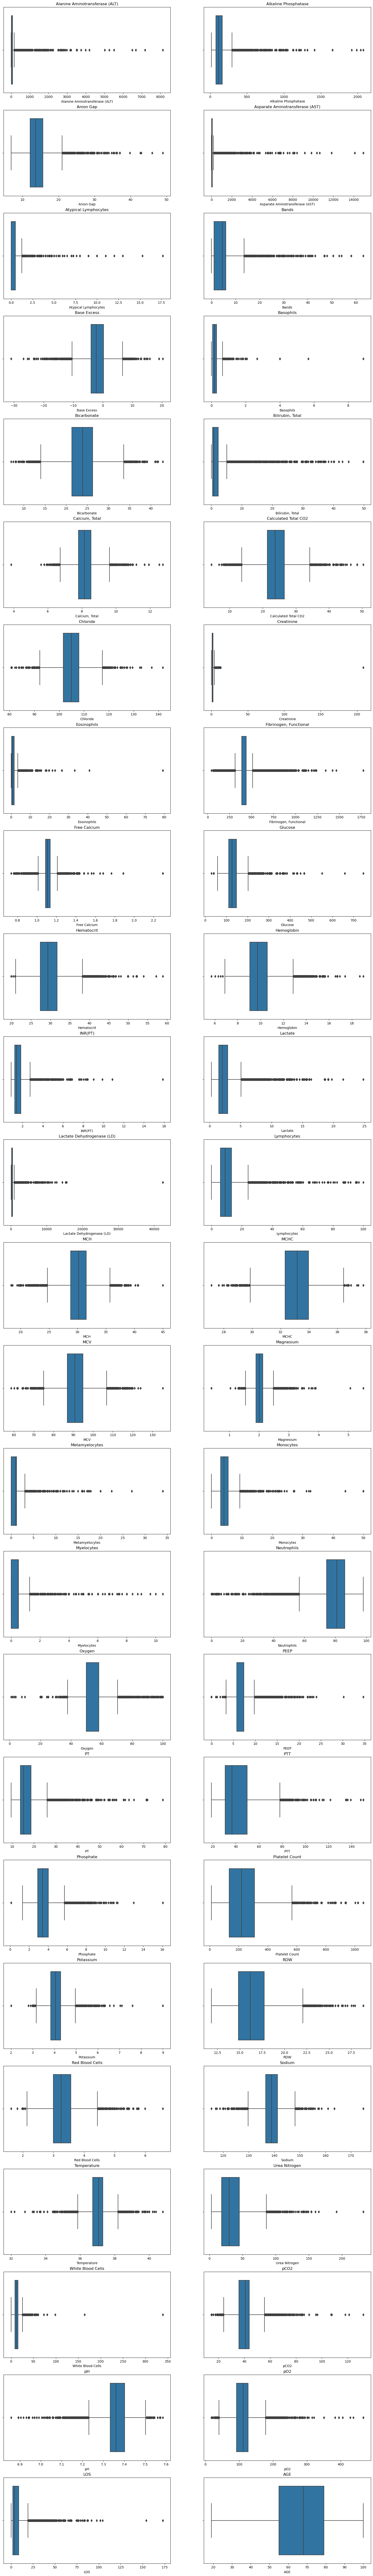

In [67]:
import seaborn as sns
# Create a boxplot for each numeric column

# Create subplots for each column
fig, axes = plt.subplots(nrows=25, ncols=2, figsize=(20, 140))

# Flatten the axes array to a list
axes = axes.flatten()

# Loop through each column and plot the boxplot
for i, col in enumerate(num_cols):
    sns.boxplot(x=final_ds[col], ax=axes[i])
    axes[i].set_title(col)

In [68]:
import warnings
# Dealing with the outliers using winsorzing

from scipy.stats.mstats import winsorize

# Percentage of data to be Winsorized (15%)
winsor_percent = 0.15

# Iterate over the columns with large maximum values
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for col in num_cols:
        if final_ds[col].max() > final_ds[col].quantile(0.75):
            print(f"Winsorizing column '{col}' with maximum value {final_ds[col].max()}")
            # Winsorize the column
            final_ds[col] = winsorize(final_ds[col], limits=(winsor_percent, winsor_percent))

Winsorizing column 'Alanine Aminotransferase (ALT)' with maximum value 8133.833333333333
Winsorizing column 'Alkaline Phosphatase' with maximum value 2075.8571428571427
Winsorizing column 'Anion Gap' with maximum value 49.0
Winsorizing column 'Asparate Aminotransferase (AST)' with maximum value 14929.5
Winsorizing column 'Atypical Lymphocytes' with maximum value 17.666666666666668
Winsorizing column 'Bands' with maximum value 63.0
Winsorizing column 'Base Excess' with maximum value 20.333333333333332
Winsorizing column 'Basophils' with maximum value 8.875
Winsorizing column 'Bicarbonate' with maximum value 42.888888888888886
Winsorizing column 'Bilirubin, Total' with maximum value 49.75454545454546
Winsorizing column 'Calcium, Total' with maximum value 12.75
Winsorizing column 'Calculated Total CO2' with maximum value 50.333333333333336
Winsorizing column 'Chloride' with maximum value 141.75
Winsorizing column 'Creatinine' with maximum value 208.55
Winsorizing column 'Eosinophils' with

In [69]:
final_ds[num_cols].describe()

,Alanine Aminotransferase (ALT),Alkaline Phosphatase,Anion Gap,Asparate Aminotransferase (AST),Atypical Lymphocytes,Bands,Base Excess,Basophils,Bicarbonate,"Bilirubin, Total","Calcium, Total",Calculated Total CO2,Chloride,Creatinine,Eosinophils,"Fibrinogen, Functional",Free Calcium,Glucose,Hematocrit,Hemoglobin,INR(PT),Lactate,Lactate Dehydrogenase (LD),Lymphocytes,MCH,MCHC,MCV,Magnesium,Metamyelocytes,Monocytes,Myelocytes,Neutrophils,Oxygen,PEEP,PT,PTT,Phosphate,Platelet Count,Potassium,RDW,Red Blood Cells,Sodium,Temperature,Urea Nitrogen,White Blood Cells,pCO2,pH,pO2,LOS,AGE
count,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000,18851.000000
mean,50.749385,128.733640,13.982787,75.197877,0.343411,4.410739,-1.901265,0.185372,23.796662,1.352418,8.174026,23.885804,104.856439,1.549002,0.969972,425.800725,1.110307,129.146481,29.663870,9.851048,1.545878,2.253841,337.315351,9.704208,30.172855,33.135965,90.997348,2.015538,0.843684,4.277524,0.336523,79.835769,56.248632,6.902534,16.469956,40.100352,3.491964,223.153505,4.061251,16.342354,3.291405,138.932375,37.050529,32.373108,12.024924,40.085207,7.364844,109.998383,5.623134,67.134051
std,38.818094,55.500666,2.081907,64.265668,0.316524,3.444799,2.633158,0.136932,2.750021,1.134448,0.399823,3.012266,3.504306,0.800368,0.800237,84.552077,0.034738,20.144216,2.536357,0.865706,0.391461,0.853550,130.181379,4.194885,1.585403,0.896118,4.423163,0.137062,0.634097,1.439909,0.313432,7.009670,6.867659,1.149922,3.156927,10.594488,0.645653,93.929867,0.253516,1.610111,0.323839,2.619438,0.381039,14.868132,3.753580,4.916261,0.040720,21.087145,4.497560,12.538590
min,14.200000,66.000000,11.364964,21.000000,0.000000,0.000000,-5.975000,0.000000,19.785714,0.333333,7.634783,19.500000,99.823529,0.700000,0.100000,282.666667,1.056667,104.333333,26.401282,8.732632,1.150000,1.250000,189.000000,4.500000,27.857500,31.843750,85.000000,1.833333,0.000000,2.400000,0.000000,68.500000,45.309859,5.000000,13.257143,28.400000,2.669492,96.900000,3.723353,14.242857,2.866957,135.163265,36.479167,14.400000,7.125455,33.062500,7.303404,79.666667,1.338500,49.000000
25%,18.250000,79.000000,12.105263,26.333333,0.000000,1.000000,-4.000000,0.066667,21.333333,0.429286,7.800000,21.333333,101.679245,0.850000,0.247368,388.000000,1.087333,110.210000,27.389083,9.060000,1.210000,1.490000,215.600000,5.836667,28.797059,32.315789,86.937500,1.893750,0.000000,3.000000,0.000000,74.300000,50.000000,5.777778,13.800000,30.677778,2.904082,134.666667,3.828571,14.845823,2.994211,136.614591,36.733333,18.240000,8.475000,35.800000,7.332899,92.000000,1.895200,55.000000
50%,33.560976,114.500000,13.677524,44.868421,0.500000,4.500000,-2.243243,0.175000,23.904762,0.800000,8.150000,23.731432,104.901235,1.276923,0.750000,437.917552,1.108592,125.852941,29.320000,9.741667,1.400000,2.040000,295.000000,9.033333,30.177778,33.179630,90.750000,2.002000,1.000000,4.133333,0.500000,80.900000,58.158110,7.413939,15.283333,36.568750,3.400000,218.625000,4.040000,16.181081,3.255000,138.911765,37.065840,29.800000,11.622222,40.620176,7.360000,111.553780,3.718900,68.000000
75%,78.500000,165.947368,15.692308,102.884615,0.503856,6.000000,0.294118,0.300000,26.257576,2.300000,8.529722,26.481481,108.000000,2.161250,1.566667,437.917552,1.136667,147.406250,31.723098,10.585714,1.821698,2.928571,515.347202,13.166667,31.550000,33.976667,94.916667,2.128571,1.243779,5.533333,0.510994,86.100000,58.158110,7.413939,18.6807

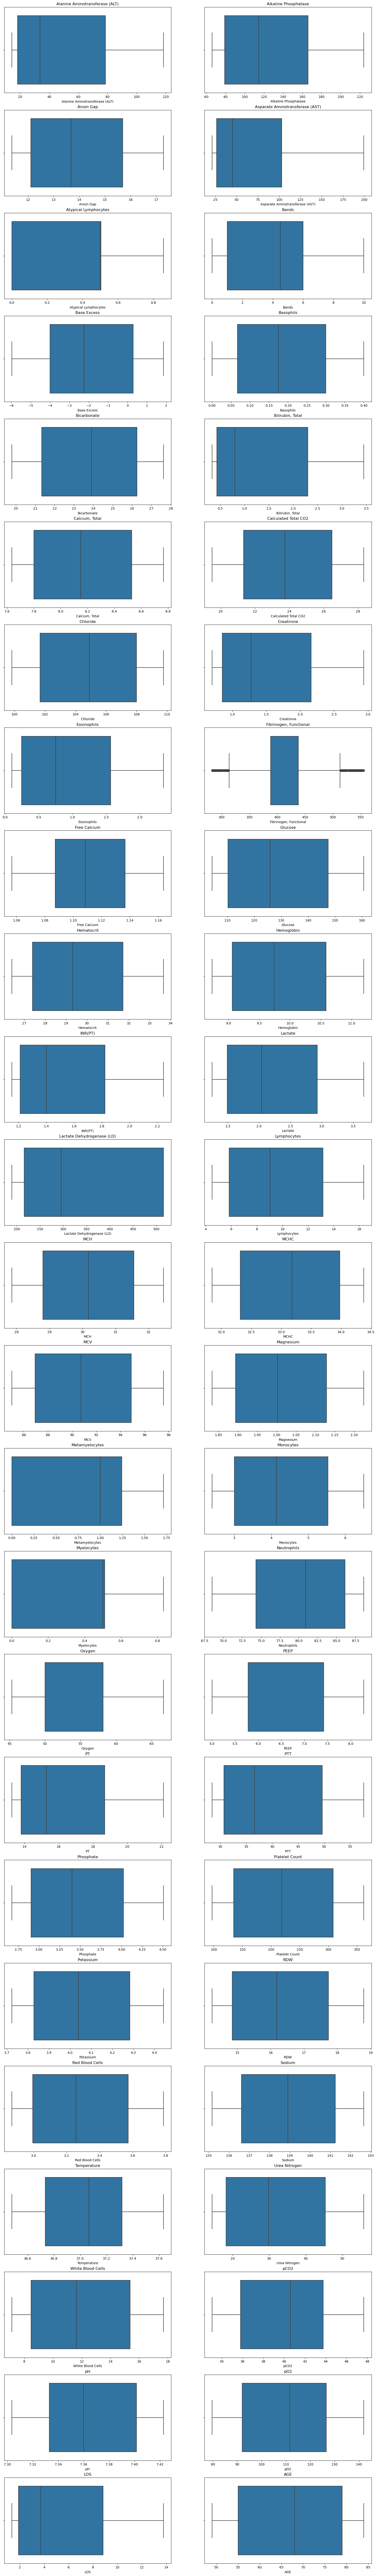

In [70]:
# Create a boxplot for each numeric column
# Create subplots for each column
fig, axes = plt.subplots(nrows=25, ncols=2, figsize=(20, 140))

# Flatten the axes array to a list
axes = axes.flatten()

# Loop through each column and plot the boxplot
for i, col in enumerate(num_cols):
    sns.boxplot(x=final_ds[col], ax=axes[i])
    axes[i].set_title(col)

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 22.12it/s]


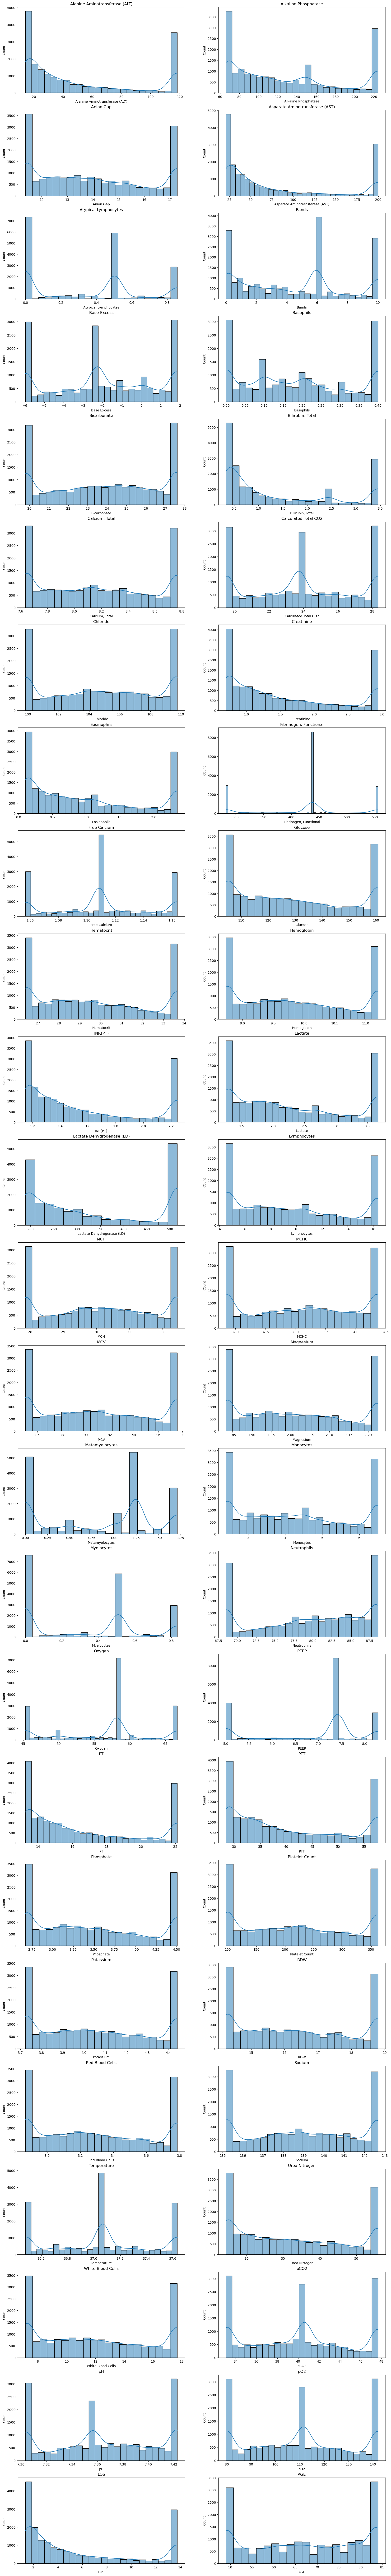

In [71]:
#Plotting the historgram for all the numerical columns
# Create subplots for each column
fig, axes = plt.subplots(nrows=25, ncols=2, figsize=(20, 140))

# Flatten the axes array to a list
axes = axes.flatten()

# Loop through each column and plot the histogram and kde
#Using tqdm to see the progress bar
for i, col in tqdm(enumerate(num_cols), total=len(num_cols)):
    sns.histplot(final_ds[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

In [72]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the numerical columns
final_ds[num_cols] = scaler.fit_transform(final_ds[num_cols])

In [73]:
#Displaying the skewness for every numerical columns
for i in num_cols:
    print(f'Skewness for the {i} is : {skew(final_ds[i])}')

Skewness for the Alanine Aminotransferase (ALT) is : 0.819832653279492
Skewness for the Alkaline Phosphatase is : 0.552410146785764
Skewness for the Anion Gap is : 0.3205130941464545
Skewness for the Asparate Aminotransferase (AST) is : 1.0900856158599561
Skewness for the Atypical Lymphocytes is : 0.23738482623771526
Skewness for the Bands is : 0.24818600614970082
Skewness for the Base Excess is : -0.11006155676097858
Skewness for the Basophils is : 0.22762120053172583
Skewness for the Bicarbonate is : -0.06902670897470434
Skewness for the Bilirubin, Total is : 0.8829128809763215
Skewness for the Calcium, Total is : 0.12753484355439304
Skewness for the Calculated Total CO2 is : 0.025949856974376205
Skewness for the Chloride is : -0.034067853171794144
Skewness for the Creatinine is : 0.6566442949301098
Skewness for the Eosinophils is : 0.6038589942721196
Skewness for the Fibrinogen, Functional is : -0.2709058671451967
Skewness for the Free Calcium is : 0.01937169841475098
Skewness for t

In [74]:
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Calculate VIF for each numerical column
    vif_data = pd.DataFrame()
    vif_data["feature"] = num_cols
    vif_data["VIF"] = [variance_inflation_factor(final_ds[num_cols].values, i)
                       for i in range(len(num_cols))]
    
    # Print VIF values for each feature
    print(vif_data)

                            feature        VIF
0    Alanine Aminotransferase (ALT)   4.938366
1              Alkaline Phosphatase   1.316584
2                         Anion Gap   4.107046
3   Asparate Aminotransferase (AST)   5.709702
4              Atypical Lymphocytes   1.168397
5                             Bands   1.634164
6                       Base Excess  21.191991
7                         Basophils   1.517884
8                       Bicarbonate   5.238640
9                  Bilirubin, Total   1.926972
10                   Calcium, Total   1.591022
11             Calculated Total CO2  22.747940
12                         Chloride   5.303484
13                       Creatinine   3.150312
14                      Eosinophils   1.582526
15           Fibrinogen, Functional   1.275982
16                     Free Calcium   1.368734
17                          Glucose   1.154290
18                       Hematocrit  22.311876
19                       Hemoglobin  21.352311
20           

In [75]:
# Get summary statistics of VIF values
print(vif_data['VIF'].describe())

count    50.000000
mean      5.042210
std       6.215264
min       1.154290
25%       1.417153
50%       1.808449
75%       4.932286
max      22.747940
Name: VIF, dtype: float64


In [76]:
# Calculate the 75th percentile of VIF values
vif_thresh = vif_data['VIF'].quantile(0.75)

# Filter the rows with VIF values above the threshold
high_vif = vif_data[vif_data['VIF'] > vif_thresh]

# Get the count of features with VIF values above the threshold
high_vif_count = len(high_vif)
print("Number of features with VIF values above the 75th percentile: ", high_vif_count)

# Drop the columns with VIF values above the threshold from final_ds
final_ds.drop(columns=high_vif['feature'], inplace=True)
print("Number of columns in final_ds after dropping columns with VIF values above the 75th percentile: ", len(final_ds.columns))


Number of features with VIF values above the 75th percentile:  13
Number of columns in final_ds after dropping columns with VIF values above the 75th percentile:  46


In [77]:
#Creating a new columns to store the numerical column names
num_cols1 = list(final_ds.select_dtypes(include=['float64', 'int64']).columns)

#Removing SUBJECT_ID, even it is integer but it wont help us in the model building
num_cols1.remove('SUBJECT_ID')

#Removing DEATH_WITHIN_90_DAYS, as it is our label value
num_cols1.remove('DEATH_WITHIN_90_DAYS')

#Removing DEATH_WITHIN_60_DAYS, as it is our label value
num_cols1.remove('DEATH_WITHIN_60_DAYS')

#Removing DEATH_WITHIN_30_DAYS, as it is our label value
num_cols1.remove('DEATH_WITHIN_30_DAYS')

print("Length of the numerical columns : ", len(num_cols1))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Calculate VIF for each numerical column
    vif_data = pd.DataFrame()
    vif_data["feature"] = num_cols1
    vif_data["VIF"] = [variance_inflation_factor(final_ds[num_cols1].values, i)
                       for i in range(len(num_cols1))]
    
    # Print VIF values for each feature
    print(vif_data)

Length of the numerical columns :  37
                       feature       VIF
0         Alkaline Phosphatase  1.225450
1                    Anion Gap  2.735569
2         Atypical Lymphocytes  1.157291
3                        Bands  1.622125
4                    Basophils  1.506207
5             Bilirubin, Total  1.629995
6               Calcium, Total  1.424880
7                   Creatinine  3.070513
8                  Eosinophils  1.563668
9       Fibrinogen, Functional  1.261625
10                Free Calcium  1.302677
11                     Glucose  1.144886
12                     Lactate  1.619065
13  Lactate Dehydrogenase (LD)  1.164518
14                 Lymphocytes  3.067527
15                        MCHC  1.448817
16                   Magnesium  1.370599
17              Metamyelocytes  1.795411
18                   Monocytes  1.432668
19                  Myelocytes  1.653716
20                 Neutrophils  3.396599
21                      Oxygen  1.195164
22                 

In [78]:
print(vif_data['VIF'].describe())

count    37.000000
mean      1.650934
std       0.625253
min       1.144886
25%       1.261625
50%       1.448817
75%       1.629995
max       3.396599
Name: VIF, dtype: float64


In [79]:
# Calculate the kurtosis of each numerical column
kurtosis = final_ds[num_cols1].kurtosis()

# Print the kurtosis values
print(kurtosis)

Alkaline Phosphatase         -1.050324
Anion Gap                    -1.241895
Atypical Lymphocytes         -1.317376
Bands                        -1.193655
Basophils                    -1.205370
Bilirubin, Total             -0.780002
Calcium, Total               -1.333224
Creatinine                   -1.019299
Eosinophils                  -1.037173
Fibrinogen, Functional       -0.601066
Free Calcium                 -0.930793
Glucose                      -1.292167
Lactate                      -1.151095
Lactate Dehydrogenase (LD)   -1.536654
Lymphocytes                  -1.240205
MCHC                         -1.344326
Magnesium                    -1.285412
Metamyelocytes               -1.463930
Monocytes                    -1.275419
Myelocytes                   -1.412173
Neutrophils                  -1.188164
Oxygen                       -0.900784
PEEP                         -0.949080
PTT                          -1.185724
Phosphate                    -1.245513
Platelet Count           

In [80]:
print(final_ds.shape)
final_ds.head()

(18851, 46)


,SUBJECT_ID,Alkaline Phosphatase,Anion Gap,Atypical Lymphocytes,Bands,Basophils,"Bilirubin, Total","Calcium, Total",Creatinine,Eosinophils,"Fibrinogen, Functional",Free Calcium,Glucose,Lactate,Lactate Dehydrogenase (LD),Lymphocytes,MCHC,Magnesium,Metamyelocytes,Monocytes,Myelocytes,Neutrophils,Oxygen,PEEP,PTT,Phosphate,Platelet Count,Potassium,RDW,Sodium,Temperature,Urea Nitrogen,White Blood Cells,pCO2,pH,pO2,CATEGORY,FIRST_CAREUNIT,LAST_CAREUNIT,LOS,ADMISSION_TYPE,GENDER,AGE,DEATH_WITHIN_90_DAYS,DEATH_WITHIN_60_DAYS,DEATH_WITHIN_30_DAYS
0,234,-0.463676,1.586533,-1.084974,-1.280439,-0.258324,-0.898332,0.748620,1.736071,-0.556065,0.143310,-0.049379,-0.512466,0.489940,-0.063877,-1.234681,-1.442053,-0.671310,-1.330564,-1.303954,-1.073699,1.250339,0.278046,0.444742,0.663280,1.576626,0.133813,1.505293,1.524282,-0.153840,0.040183,1.070843,1.511572,-0.220744,1.422785,0.664006,Hematology,CCU,CCU,-0.102710,EMERGENCY,M,-1.207030,0,0,0
12,250,0.703008,-0.387307,1.623084,1.622565,-1.353784,-0.516345,0.356769,-1.060792,-1.087172,-0.551557,1.538489,-0.217880,1.658282,1.367604,-0.565197,1.388285,-1.051446,0.772220,-0.424245,1.585104,-1.308099,1.517010,1.202879,1.656847,0.820548,-0.337710,1.278228,-0.567346,-0.872468,-0.994937,-1.208866,0.879056,0.559819,0.930635,1.517629,Hematology,MICU,CSRU,1.121252,EMERGENCY,F,-1.446298,1,1,1
18,395,-1.130352,-0.712244,-1.084974,1.622565,0.350264,-0.898332,0.315083,-0.654718,1.724570,0.143310,-0.049379,-0.602992,-0.012869,-0.478694,0.769797,0.852627,-1.329395,-1.330564,0.895318,-1.073699,-0.837309,0.278046,0.444742,-1.104410,-0.894745,1.221385,-0.389536,-0.911362,0.693917,0.040183,-0.605210,-0.825880,1.542160,-1.508886,-1.438437,Hematology,MICU,MICU,-0.952683,EMERGENCY,F,0.547600,0,0,0
23,419,1.449865,-1.174889,-1.084974,0.712957,-1.145125,1.741997,0.478425,-1.060792,-0.997911,1.533998,0.798337,0.077685,0.395520,-1.139328,1.548544,1.388285,0.424632,0.772220,0.412471,1.585104,-1.325763,1.517010,1.202879,-0.857299,0.239935,-1.344161,-1.332879,0.656895,0.902334,-0.821535,-0.547225,-0.870096,0.551468,1.193115,0.168694,Hematology,MICU,SICU,1.812735,EMERGENCY,F,-0.648739,0,0,0
28,441,1.255376,0.975486,1.021294,0.422656,-0.866913,0.604495,1.482298,0.207824,1.370499,-1.692896,1.538489,0.143657,1.658282,1.367604,-0.358591,0.425589,-1.329395,0.772220,1.543525,1.478752,-1.617205,1.517010,0.409036,-0.331172,1.387928,-0.207294,-0.200894,1.368252,1.422542,1.529554,1.415160,0.783027,-1.386216,1.422785,0.189771,Hematology,MICU,SICU,1.812735,EMERGENCY,F,-1.446298,0,0,0


/var/folders/rf/kgt_m29s7c5d2lwhcs92kgyc0000gn/T/ipykernel_32906/3881181590.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = corr_df.corr()


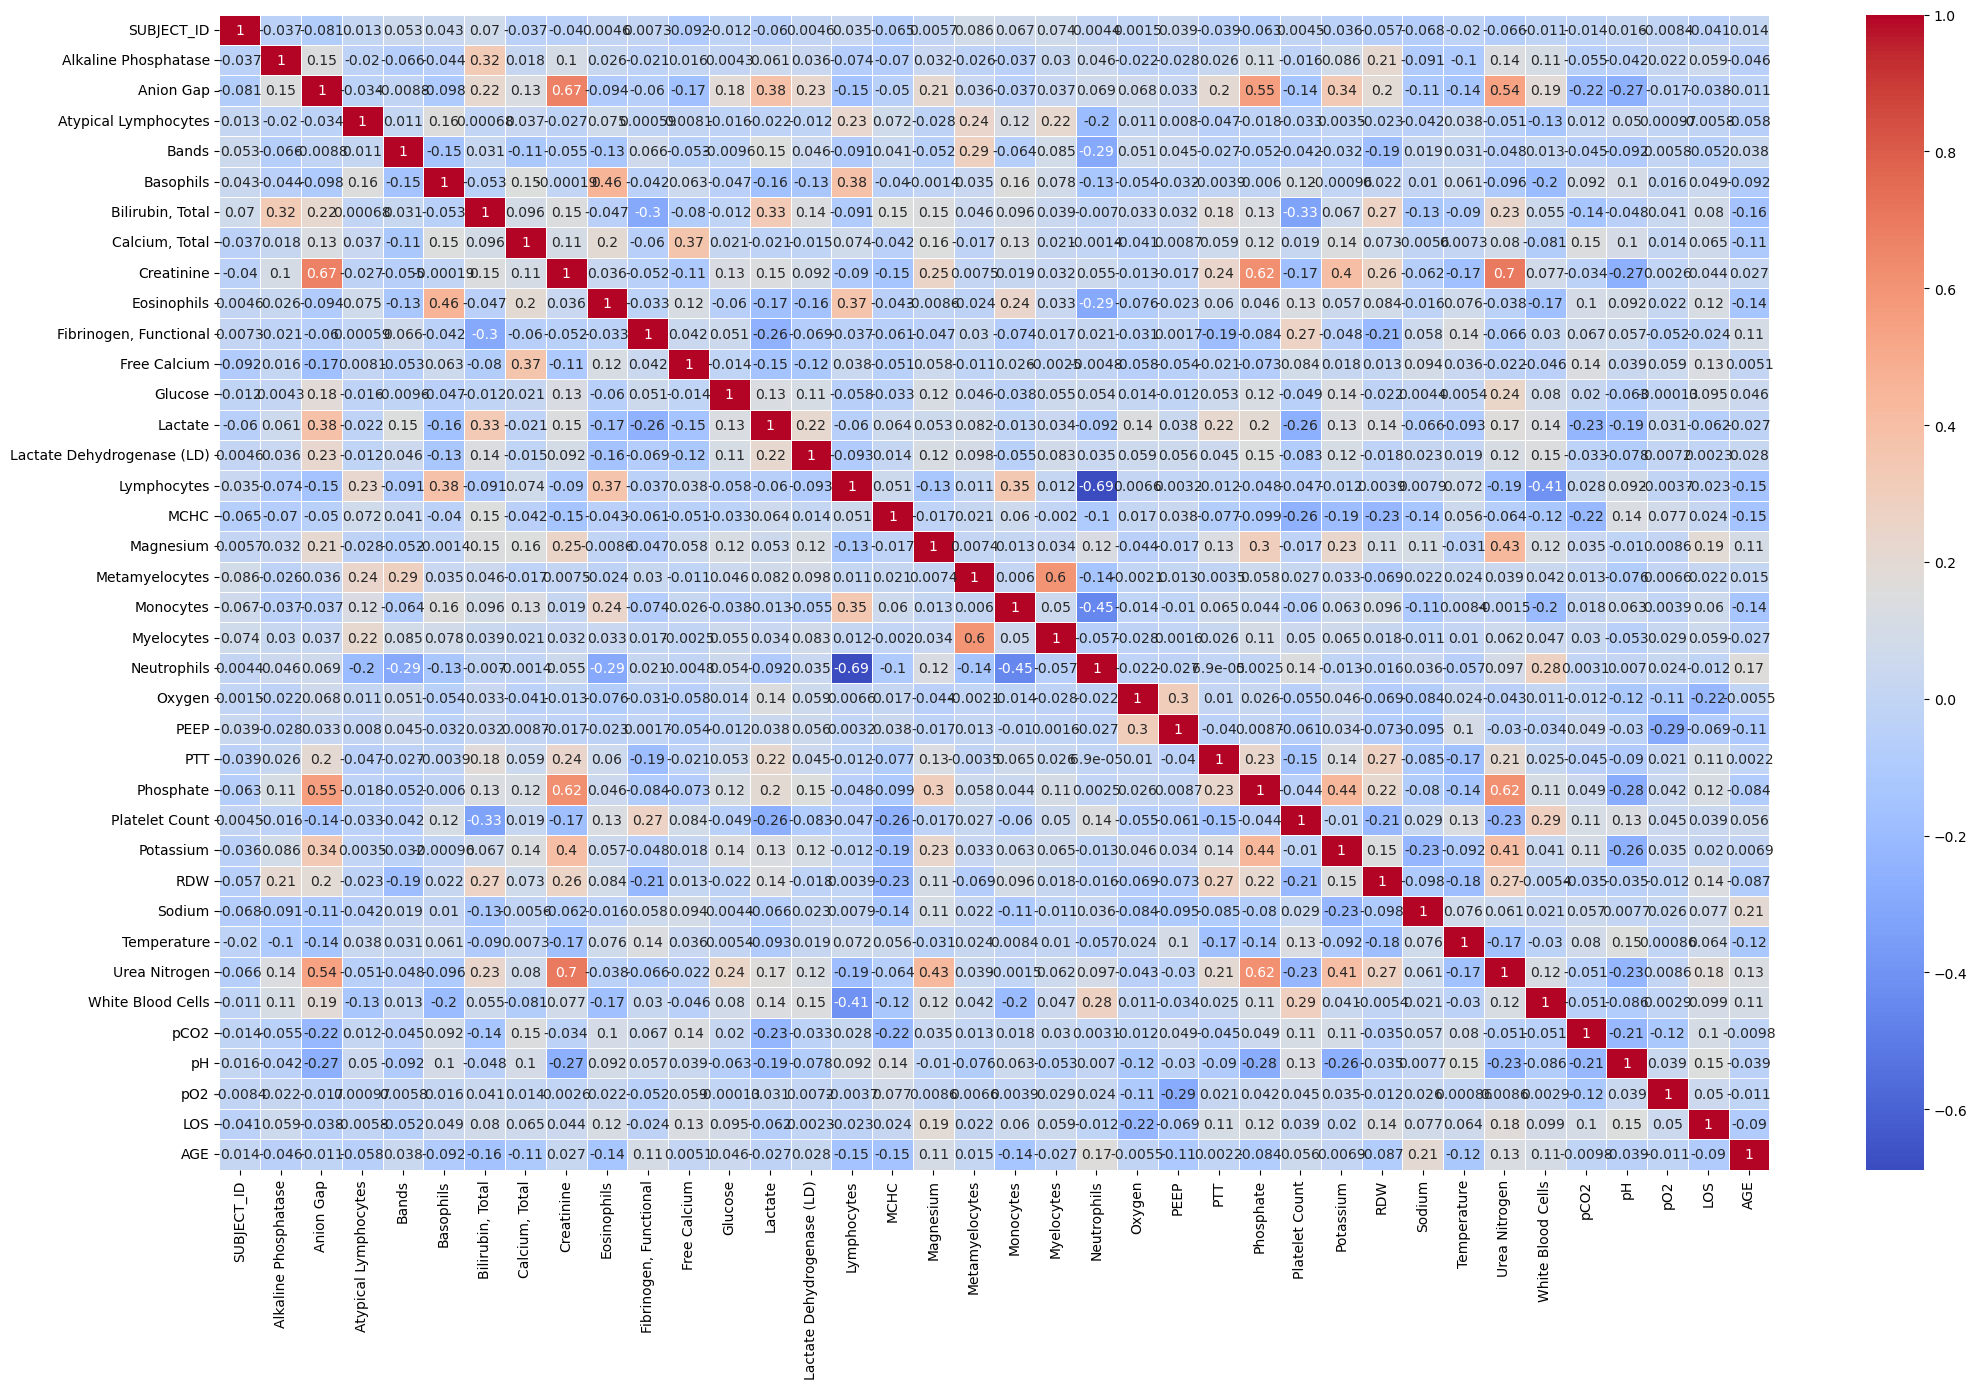

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# columns to exclude from the list
exclude_cols = ['DEATH_WITHIN_90_DAYS', 'DEATH_WITHIN_60_DAYS', 'DEATH_WITHIN_30_DAYS']

# create a list of all columns in final_ds except for the excluded columns
cols = [col for col in final_ds.columns if col not in exclude_cols]

# select the columns from final_ds
corr_df = final_ds[cols]

# calculate the correlation matrix
corr_matrix = corr_df.corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(25, 15))

# Generate a heatmap with the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Show the plot
plt.show()

In [83]:
# Set the correlation threshold
corr_threshold = 0.5

# Create an empty list to store correlated features
correlated_features = []

# Calculate the correlation matrix
corr_matrix1 = corr_matrix.abs()

# Iterate through the correlation matrix and find correlated features
for i in range(len(corr_matrix1.columns)):
    for j in range(i):
        if corr_matrix1.iloc[i, j] > corr_threshold:
            feature_i = corr_matrix1.columns[i]
            feature_j = corr_matrix1.columns[j]
            correlated_features.append((feature_i, feature_j))

# Print the list of correlated features
print(correlated_features)

[('Creatinine', 'Anion Gap'), ('Myelocytes', 'Metamyelocytes'), ('Neutrophils', 'Lymphocytes'), ('Phosphate', 'Anion Gap'), ('Phosphate', 'Creatinine'), ('Urea Nitrogen', 'Anion Gap'), ('Urea Nitrogen', 'Creatinine'), ('Urea Nitrogen', 'Phosphate')]


In [84]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew

# Create an empty list to store the columns to be dropped
cols_to_drop = []

# Loop through each pair of correlated features
for feature_pair in correlated_features:
    feature_i = feature_pair[0]
    feature_j = feature_pair[1]
    
    # Calculate the VIF for each feature
    vif_i = variance_inflation_factor(final_ds[[feature_i, feature_j]].values, 0)
    vif_j = variance_inflation_factor(final_ds[[feature_i, feature_j]].values, 1)
    
    # Calculate the skewness for each feature
    skew_i = skew(final_ds[feature_i])
    skew_j = skew(final_ds[feature_j])
    
    # Determine which feature to drop based on VIF and skewness
    if vif_i > vif_j:
        cols_to_drop.append(feature_i)
    elif vif_i < vif_j:
        cols_to_drop.append(feature_j)
    else:
        if skew_i > skew_j:
            cols_to_drop.append(feature_i)
        else:
            cols_to_drop.append(feature_j)
            
# Drop the columns from final_ds
print(cols_to_drop)
final_ds = final_ds.drop(cols_to_drop, axis=1)

['Creatinine', 'Metamyelocytes', 'Lymphocytes', 'Anion Gap', 'Creatinine', 'Anion Gap', 'Creatinine', 'Urea Nitrogen']


In [85]:
print(final_ds.shape)
final_ds.head()

(18851, 41)


,SUBJECT_ID,Alkaline Phosphatase,Atypical Lymphocytes,Bands,Basophils,"Bilirubin, Total","Calcium, Total",Eosinophils,"Fibrinogen, Functional",Free Calcium,Glucose,Lactate,Lactate Dehydrogenase (LD),MCHC,Magnesium,Monocytes,Myelocytes,Neutrophils,Oxygen,PEEP,PTT,Phosphate,Platelet Count,Potassium,RDW,Sodium,Temperature,White Blood Cells,pCO2,pH,pO2,CATEGORY,FIRST_CAREUNIT,LAST_CAREUNIT,LOS,ADMISSION_TYPE,GENDER,AGE,DEATH_WITHIN_90_DAYS,DEATH_WITHIN_60_DAYS,DEATH_WITHIN_30_DAYS
0,234,-0.463676,-1.084974,-1.280439,-0.258324,-0.898332,0.748620,-0.556065,0.143310,-0.049379,-0.512466,0.489940,-0.063877,-1.442053,-0.671310,-1.303954,-1.073699,1.250339,0.278046,0.444742,0.663280,1.576626,0.133813,1.505293,1.524282,-0.153840,0.040183,1.511572,-0.220744,1.422785,0.664006,Hematology,CCU,CCU,-0.102710,EMERGENCY,M,-1.207030,0,0,0
12,250,0.703008,1.623084,1.622565,-1.353784,-0.516345,0.356769,-1.087172,-0.551557,1.538489,-0.217880,1.658282,1.367604,1.388285,-1.051446,-0.424245,1.585104,-1.308099,1.517010,1.202879,1.656847,0.820548,-0.337710,1.278228,-0.567346,-0.872468,-0.994937,0.879056,0.559819,0.930635,1.517629,Hematology,MICU,CSRU,1.121252,EMERGENCY,F,-1.446298,1,1,1
18,395,-1.130352,-1.084974,1.622565,0.350264,-0.898332,0.315083,1.724570,0.143310,-0.049379,-0.602992,-0.012869,-0.478694,0.852627,-1.329395,0.895318,-1.073699,-0.837309,0.278046,0.444742,-1.104410,-0.894745,1.221385,-0.389536,-0.911362,0.693917,0.040183,-0.825880,1.542160,-1.508886,-1.438437,Hematology,MICU,MICU,-0.952683,EMERGENCY,F,0.547600,0,0,0
23,419,1.449865,-1.084974,0.712957,-1.145125,1.741997,0.478425,-0.997911,1.533998,0.798337,0.077685,0.395520,-1.139328,1.388285,0.424632,0.412471,1.585104,-1.325763,1.517010,1.202879,-0.857299,0.239935,-1.344161,-1.332879,0.656895,0.902334,-0.821535,-0.870096,0.551468,1.193115,0.168694,Hematology,MICU,SICU,1.812735,EMERGENCY,F,-0.648739,0,0,0
28,441,1.255376,1.021294,0.422656,-0.866913,0.604495,1.482298,1.370499,-1.692896,1.538489,0.143657,1.658282,1.367604,0.425589,-1.329395,1.543525,1.478752,-1.617205,1.517010,0.409036,-0.331172,1.387928,-0.207294,-0.200894,1.368252,1.422542,1.529554,0.783027,-1.386216,1.422785,0.189771,Hematology,MICU,SICU,1.812735,EMERGENCY,F,-1.446298,0,0,0


In [87]:
final_ds.describe()

,SUBJECT_ID,Alkaline Phosphatase,Atypical Lymphocytes,Bands,Basophils,"Bilirubin, Total","Calcium, Total",Eosinophils,"Fibrinogen, Functional",Free Calcium,Glucose,Lactate,Lactate Dehydrogenase (LD),MCHC,Magnesium,Monocytes,Myelocytes,Neutrophils,Oxygen,PEEP,PTT,Phosphate,Platelet Count,Potassium,RDW,Sodium,Temperature,White Blood Cells,pCO2,pH,pO2,LOS,AGE,DEATH_WITHIN_90_DAYS,DEATH_WITHIN_60_DAYS,DEATH_WITHIN_30_DAYS
count,18851.000000,1.885100e+04,18851.000000,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,1.885100e+04,18851.000000,18851.000000,18851.000000
mean,39028.494085,2.683711e-16,0.000000,9.800070e-18,1.952475e-16,7.086204e-17,-5.214579e-15,-7.236974e-17,6.739432e-16,-2.223862e-15,1.869552e-16,1.051623e-16,-1.206162e-17,1.788136e-15,-8.118981e-16,-3.354639e-17,9.272374e-17,-2.261555e-16,-1.480564e-15,3.316947e-17,-3.158638e-16,-7.621439e-16,-1.816782e-16,-2.545757e-15,4.055721e-16,-3.972797e-15,-1.739814e-14,3.822027e-16,-2.623403e-16,-1.996199e-15,-2.721404e-16,-1.809244e-17,-4.025567e-16,0.317118,0.307729,0.270596
std,29377.848902,1.000027e+00,1.000027,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,0.465366,0.461566,0.444279
min,21.000000,-1.130352e+00,-1.084974,-1.280439e+00,-1.353784e+00,-8.983323e-01,-1.348742e+00,-1.087172e+00,-1.692896e+00,-1.544184e+00,-1.231808e+00,-1.176109e+00,-1.139328e+00,-1.442053e+00,-1.329395e+00,-1.303954e+00,-1.073699e+00,-1.617205e+00,-1.592837e+00,-1.654534e+00,-1.104410e+00,-1.273897e+00,-1.344161e+00,-1.332879e+00,-1.303981e+00,-1.438938e+00,-1.499523e+00,-1.305314e+00,-1.428503e+00,-1.508886e+00,-1.438437e+00,-9.526826e-01,-1.446298e+00,0.000000,0.000000,0.000000
25%,14541.500000,-8.961146e-01,-1.084974,-9.901388e-01,-8.669131e-01,-8.137494e-01,-9.355042e-01,-9.030114e-01,-4.470822e-01,-6.613639e-01,-9.400705e-01,-8.949226e-01,-9.349922e-01,-9.152784e-01,-8.885853e-01,-8.872496e-01,-1.073699e+00,-7.897541e-01,-9.098876e-01,-9.781415e-01,-8.894082e-01,-9.105493e-01,-9.420772e-01,-9.178335e-01,-9.294836e-01,-8.848636e-01,-8.324698e-01,-9.457688e-01,-8.716625e-01,-7.845411e-01,-8.535466e-01,-8.289011e-01,-9.677621e-01,0.000000,0.000000,0.000000
50%,28813.000000,-2.564657e-01,0.494727,2.591253e-02,-7.574784e-02,-4.869615e-01,-6.009325e-02,-2.748912e-01,1.433099e-01,-4.937875e-02,-1.635024e-01,-2.505381e-01,-3.250578e-01,4.872724e-02,-9.877588e-02,-1.001417e-01,5.215828e-01,1.518273e-01,2.780464e-01,4.447416e-01,-3.333522e-01,-1.424402e-01,-4.821283e-02,-8.382733e-02,-1.001656e-01,-7.868275e-03,4.018333e-02,-1.072876e-01,1.088191e-01,-1.189619e-01,7.376242e-02,-4.234038e-01,6.906452e-02,0.000000,0.000000,0.000000
75%,63992.000000,6.705274e-01,0.506909,4.613631e-01,8.371352e-01,8.353021e-01,8.896582e-01,7.456671e-01,1.433099e-01,7.588246e-01,9.064763e-01,7.905194e-01,1.367604e+00,9.381837e-01,8.247096e-01,8.721680e-01,5.566590e-01,8.936794e-01,2.780464e-01,4.447416e-01,9.005964e-01,8.246540e-01,9.030540e-01,8.773728e-01,8.646650e-01,8.848032e-01,7.024478e-01,8.918058e-01,7.450833e-01,9.030425e-01,7.854101e-01,7.105077e-01,9.463794e-01,1.000000,1.000000,1.000000
max,99991.000000,1.716536e+00,1.623084,1.622565e+00,1.567442e+00,1.849037e+00,1.482298e+00,1.724570e+00,1.533998e+00,1.538489e+00,1.565768e+00,1.658282e+00,1.367604e+00,1.388285e+00,1.528268e+00,1.543525e+00,1.585104e+00,1.250339e+00,1.517010e+00,1.202879e+00,1.65684

In [ ]:
final_ds.to_csv('final_dataframe.csv', index=False)

#Defining MinMaxScaler 
scaler = MinMaxScaler()

# fit scaler on data
scaler.fit(final_ds[num_cols])

# transforming the data
scaled_data = scaler.transform(final_ds[num_cols])

# replace original numeric columns with scaled values
final_ds[num_cols] = scaled_data

final_ds.head(5)

#Performing One-Hot encoding on the categorical colums
final_ds = pd.get_dummies(final_ds,columns=['CATEGORY','FIRST_CAREUNIT','LAST_CAREUNIT','ADMISSION_TYPE','GENDER'])

#Dropping subject_id as it is no longed needed.
final_ds.drop(['SUBJECT_ID'],axis=1,inplace=True)

#Displaying the shape of the dataste
print("Shape of the dataset is : ",final_ds.shape)

#Displaying the first 5 rows of the final dataset
final_ds.head(5)

### Methodology

1. Explan your Deep Learning process / methodology



2. Introduce the Deep Neural Networks you used in your project
 * Model 1
    * Description 
 
 * Model 2
    * Description
 
 * Ensemble method
     * Description 
 
 
3. Add keywords  
**Keywords:** natural language processing, sentiment analysis, clustering, binary classification, multi-label classification, prediction
	___
 **Example**
* ConvNet
    * A convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery(source Wikipedia). 
 
* **Keywords:** supervised learning, classification, ...

### Model Fitting and Validation

1. model 1 
    - decription 
2. model 2
    - decription 

In [ ]:
## Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten

final_ds['CATEGORY'] = final_ds['CATEGORY'].astype('category')
final_ds['FIRST_CAREUNIT'] = final_ds['FIRST_CAREUNIT'].astype('category')
final_ds['LAST_CAREUNIT'] = final_ds['LAST_CAREUNIT'].astype('category')
final_ds['ADMISSION_TYPE'] = final_ds['ADMISSION_TYPE'].astype('category')
final_ds['GENDER'] = final_ds['GENDER'].astype('category')

# Perform multi-label encoding on 'LAST_CAREUNIT'
category_encoded = pd.get_dummies(final_ds['CATEGORY'], prefix='CATEGORY')
first_careunit_encoded = pd.get_dummies(final_ds['FIRST_CAREUNIT'], prefix='FIRST_CAREUNIT')
last_careunit_encoded = pd.get_dummies(final_ds['LAST_CAREUNIT'], prefix='LAST_CAREUNIT')
admission_type_encoded = pd.get_dummies(final_ds['ADMISSION_TYPE'], prefix='ADMISSION_TYPE')
gender_encoded = pd.get_dummies(final_ds['GENDER'], prefix='GENDER')

# Drop original 'LAST_CAREUNIT' column and concatenate the encoded columns to the final_ds dataframe
final_ds.drop('CATEGORY', axis=1, inplace=True)
final_ds = pd.concat([final_ds, category_encoded], axis=1)
final_ds.drop('FIRST_CAREUNIT', axis=1, inplace=True)
final_ds = pd.concat([final_ds, first_careunit_encoded], axis=1)
final_ds.drop('LAST_CAREUNIT', axis=1, inplace=True)
final_ds = pd.concat([final_ds, last_careunit_encoded], axis=1)
final_ds.drop('ADMISSION_TYPE', axis=1, inplace=True)
final_ds = pd.concat([final_ds, admission_type_encoded], axis=1)
final_ds.drop('GENDER', axis=1, inplace=True)
final_ds = pd.concat([final_ds, gender_encoded], axis=1)

In [ ]:
import random
# Read the CSV file
final_ds = pd.read_csv('final_dataframe.csv')

# Select a random subset of 10 records
random_subset = final_ds.sample(n=10, random_state=random.seed())

# Save the selected records to a new CSV file
random_subset.to_csv('demo_file.csv', index=False)

# Drop the selected 10 rows from the original dataframe
final_ds.drop(index=random_subset.index, inplace=True)

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv1D,GRU, LSTM, MaxPooling1D, BatchNormalization, Flatten, Dense, Dropout


#class counts
class_counts1 = final_ds['DEATH_WITHIN_90_DAYS'].value_counts()
print(class_counts1)

# Separate the target variable from the features
X1 = final_ds.drop(['DEATH_WITHIN_90_DAYS','DEATH_WITHIN_60_DAYS', 'DEATH_WITHIN_30_DAYS'], axis=1)
y1 = final_ds['DEATH_WITHIN_90_DAYS']

# Balance the dataset using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X1, y1 = oversampler.fit_resample(X1, y1)

#class counts after RandomOverSampler
class_counts3 = pd.Series(y1).value_counts()
print(class_counts3)

# Split the data into training, validation, and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Define the model architecture
keras.backend.clear_session()
model1 = Sequential()
model1.add(GRU(units=32, input_shape=(X_train.shape[1], 1)))
model1.add(Dropout(rate=0.2))
model1.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_acc = model1.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

In [ ]:
model1.summary()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict probabilities for the test set
y_pred_prob = model1.predict(X_test)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (AUC = {auc_score:.2f})')
plt.show()

In [ ]:
# Get the model's predictions on the test set
y_pred = model1.predict(X_test)
y_pred_classes = np.round(y_pred).flatten().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## GRU KERAS TUNER

In [ ]:
import keras_tuner as kt
# Here were are building a model based on our hyper parameter
def model_builder(hp):
    keras.backend.clear_session()
    model = Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(GRU(units=hp_units, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    # Now, Let's tune the learning rate for the optimizer ADAM
    # Choose an optimal value from the 0.01, 0.001, or 0.0001 values
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
                  loss=keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [ ]:
tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=50, 
                     directory='project_trail1', project_name='intro_to_kt')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, batch_size=64, 
             validation_data=(X_val, y_val), callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Building the best model using keras functional API using the best hyperparameters
best_model1 = model_builder(best_hps)

# Train the best model on the full training data
history_best1 = best_model1.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_acc = best_model1.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Plot the training and validation losses
plt.plot(history_best1.history['loss'], label='Training Loss')
plt.plot(history_best1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.plot(history_best1.history['accuracy'], label='Training Accuracy')
plt.plot(history_best1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict probabilities for the test set
y_pred_prob = best_model1.predict(X_test)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (AUC = {auc_score:.2f})')
plt.show()

# Get the model's predictions on the test set
y_pred = best_model1.predict(X_test)
y_pred_classes = np.round(y_pred).flatten().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
best_model1.summary()

In [ ]:
#class counts
class_counts2 = final_ds['DEATH_WITHIN_90_DAYS'].value_counts()
print(class_counts2)

# Separate the target variable from the features
X2 = final_ds.drop(['DEATH_WITHIN_90_DAYS','DEATH_WITHIN_60_DAYS', 'DEATH_WITHIN_30_DAYS'], axis=1)
y2 = final_ds['DEATH_WITHIN_90_DAYS']

# Balance the dataset using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X2, y2 = oversampler.fit_resample(X2, y2)

#class counts after RandomOverSampler
class_counts2 = pd.Series(y2).value_counts()
print(class_counts2)

# Split the data into training, validation, and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X2, y2, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Define the model architecture
keras.backend.clear_session()
model2 = Sequential()
model2.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model2.add(Dropout(rate=0.2))
model2.add(LSTM(units=32))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_acc = model2.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

In [ ]:
model2.summary()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the model's predictions on the test set
y_pred = best_model1.predict(X_val)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)

# Print the accuracy, precision, and recall
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the model's predictions on the test set
y_pred = best_model1.predict(X_train)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_train, y_pred_binary)
precision = precision_score(y_train, y_pred_binary)
recall = recall_score(y_train, y_pred_binary)
f1 = f1_score(y_train, y_pred_binary)

# Print the accuracy, precision, and recall
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the model's predictions on the test set
y_pred = best_model1.predict(X_test)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Print the accuracy, precision, and recall
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

In [ ]:
# Plot the training and validation losses
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict probabilities for the test set
y_pred_prob = model2.predict(X_test)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (AUC = {auc_score:.2f})')
plt.show()

In [ ]:
# Get the model's predictions on the test set
y_pred = model2.predict(X_test)
y_pred_classes = np.round(y_pred).flatten().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import keras_tuner as kt
# Here were are building a model based on our hyper parameter
def model_builder(hp):
    keras.backend.clear_session()
    model = Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_units1 = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(rate=0.2))
    model.add(LSTM(units=hp_units1))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    # Now, Let's tune the learning rate for the optimizer ADAM
    # Choose an optimal value from the 0.01, 0.001, or 0.0001 values
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

In [ ]:
tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=50, 
                     directory='project_trail2', project_name='intro_to_kt')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, batch_size=64, 
             validation_data=(X_val, y_val), callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Building the best model using keras functional API using the best hyperparameters
best_model2 = model_builder(best_hps)

# Train the best model on the full training data
history_best2 = best_model2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_acc = best_model2.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Plot the training and validation losses
plt.plot(history_best2.history['loss'], label='Training Loss')
plt.plot(history_best2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.plot(history_best2.history['accuracy'], label='Training Accuracy')
plt.plot(history_best2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict probabilities for the test set
y_pred_prob = best_model2.predict(X_test)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (AUC = {auc_score:.2f})')
plt.show()

# Get the model's predictions on the test set
y_pred = best_model2.predict(X_test)
y_pred_classes = np.round(y_pred).flatten().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
best_model2.summary()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate the model's predictions on the test set
y_pred = best_model2.predict(X_test)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

# Print the accuracy, precision, and recall
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the model's predictions on the test set
y_pred = best_model2.predict(X_test)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Print the accuracy, precision, and recall
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the model's predictions on the test set
y_pred = best_model2.predict(X_train)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_train, y_pred_binary)
precision = precision_score(y_train, y_pred_binary)
recall = recall_score(y_train, y_pred_binary)
f1 = f1_score(y_train, y_pred_binary)

# Print the accuracy, precision, and recall
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the model's predictions on the test set
y_pred = best_model2.predict(X_val)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)

# Print the accuracy, precision, and recall
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

In [ ]:
#Class counts
class_counts3 = final_ds['DEATH_WITHIN_90_DAYS'].value_counts()
print(class_counts3)

# Separate the target variable from the features
X3 = final_ds.drop(['DEATH_WITHIN_90_DAYS','DEATH_WITHIN_60_DAYS', 'DEATH_WITHIN_30_DAYS'], axis=1)
y3 = final_ds['DEATH_WITHIN_90_DAYS']

# Balance the dataset using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X3, y3 = oversampler.fit_resample(X3, y3)

#class counts
class_counts3 = pd.Series(y3).value_counts()
print(class_counts3)

# Split the data into training, validation, and testing sets
#splitting the data into 70,15,15 for training, validation and testing purposes

X_train, X_val_test, y_train, y_val_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Define the Convnet model architecture
keras.backend.clear_session()
model3 = Sequential()
model3.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model3.add(MaxPooling1D(pool_size=2))
model3.add(BatchNormalization())
model3.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(BatchNormalization())
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.15))
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert DataFrames to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Reshape input data for Conv1D layer
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history3 = model3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_acc = model3.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

In [ ]:
model3.summary()

In [ ]:
# Plot the training and validation losses
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict probabilities for the test set
y_pred_prob = model3.predict(X_test)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (AUC = {auc_score:.2f})')
plt.show()

In [ ]:
# Get the model's predictions on the test set
y_pred = model3.predict(X_test)
y_pred_classes = np.round(y_pred).flatten().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import joblib

# save the trained model as a .pkl file
joblib.dump(model3, 'model3.pkl')


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the model's predictions on the test set
y_pred = model3.predict(X_test)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Print the accuracy, precision, and recall
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the model's predictions on the test set
y_pred = model3.predict(X_train)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_train, y_pred_binary)
precision = precision_score(y_train, y_pred_binary)
recall = recall_score(y_train, y_pred_binary)
f1 = f1_score(y_train, y_pred_binary)

# Print the accuracy, precision, and recall
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

In [ ]:
# Calculate the model's predictions on the test set
y_pred = model3.predict(X_val)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)

# Print the accuracy, precision, and recall
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

In [ ]:
plt.plot(history_best1.history['accuracy'])
plt.plot(history_best1.history['val_accuracy'])
plt.plot(history_best2.history['accuracy'])
plt.plot(history_best2.history['val_accuracy'])
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['GRU_best_model1_train', 'GRU_best_model1_val', 'LSTM_best_model2_train', 'LSTM_best_model2_val', 'CNN_model3_train', 'CNN_model3_val'], loc='lower right')
plt.show()

plt.plot(history_best1.history['loss'])
plt.plot(history_best1.history['val_loss'])
plt.plot(history_best2.history['loss'])
plt.plot(history_best2.history['val_loss'])
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['GRU_best_model1_train', 'GRU_best_model1_val', 'LSTM_best_model2_train', 'LSTM_best_model2_val', 'CNN_model3_train', 'CNN_model3_val'], loc='upper right')
plt.show()

## Demo of the Best Model

In [ ]:
import pandas as pd
import joblib  # import the joblib module to load the pre-trained model

# Read the new data into a dataframe
new_data = pd.read_csv('demo_file.csv')

# Make predictions on the new data using the pre-trained model
predictions = model3.predict(new_data)

predict_binary = predictions.round().astype(int)

# Print the predictions
print(predict_binary)

In [ ]:
king

In [ ]:
#class counts
class_counts4 = final_ds['DEATH_WITHIN_60_DAYS'].value_counts()
print(class_counts4)

# Separate the target variable from the features
X4 = final_ds.drop(['DEATH_WITHIN_90_DAYS','DEATH_WITHIN_60_DAYS', 'DEATH_WITHIN_30_DAYS'], axis=1)
y4 = final_ds['DEATH_WITHIN_60_DAYS']

# Balance the dataset using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X4, y4 = oversampler.fit_resample(X4, y4)

#class counts after RandomOverSampler
class_counts1 = pd.Series(y4).value_counts()
print(class_counts4)

# Split the data into training, validation, and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X4, y4, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Define the model architecture
keras.backend.clear_session()
model4 = Sequential()
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model4.add(MaxPooling1D(pool_size=2))
model4.add(BatchNormalization())
model4.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(BatchNormalization())
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.15))
model4.add(Dense(1, activation='sigmoid'))

# Compile the model
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert DataFrames to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Reshape input data for Conv1D layer
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history4 = model4.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_acc = model4.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

In [ ]:
# Plot the training and validation losses
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict probabilities for the test set
y_pred_prob = model4.predict(X_test)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (AUC = {auc_score:.2f})')
plt.show()

In [ ]:
# Get the model's predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred).flatten().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#class counts
class_counts5 = final_ds['DEATH_WITHIN_30_DAYS'].value_counts()
print(class_counts5)

# Separate the target variable from the features
X5 = final_ds.drop(['DEATH_WITHIN_90_DAYS','DEATH_WITHIN_60_DAYS', 'DEATH_WITHIN_30_DAYS'], axis=1)
y5 = final_ds['DEATH_WITHIN_30_DAYS']

# Balance the dataset using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X5, y5 = oversampler.fit_resample(X5, y5)

#class counts after RandomOverSampler
class_counts5 = pd.Series(y5).value_counts()
print(class_counts5)

# Split the data into training, validation, and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X5, y5, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Define the model architecture
keras.backend.clear_session()
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert DataFrames to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Reshape input data for Conv1D layer
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

In [ ]:
# Plot the training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict probabilities for the test set
y_pred_prob = model.predict(X_test)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (AUC = {auc_score:.2f})')
plt.show()


In [ ]:
# Get the model's predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred).flatten().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Model Evaluation 

* Examine your models (coefficients, parameters, errors, etc...)

* Compute and interpret your results in terms of accuracy, precision, recall, ROC etc. 

In [ ]:
## Your code begins here

### Issues / Improvements
1. Dataset is very small
2. Use regularization / initialization
3. Use cross-validaiton
4. ...

###  References
   - Academic (if any)
   - Online (if any)
	

### Credits

- If you use and/or adapt your code from existing projects, you must provide links and acknowldge the authors. Keep in mind that all documents in your projects and code will be check against the official plagiarism detection tool used by Penn State ([Turnitin](https://turnitin.psu.edu))

> *This code is based on .... (if any)*

In [ ]:
# End of Project